In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('../data/nfp2/nfp2.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV

data_df_clean = data_df.dropna(subset=['quasisymmetry'])

X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = data_df_clean[['quasisymmetry', 'quasiisodynamic', 'rotational_transform', 'inverse_aspect_ratio', 'mean_local_magnetic_shear', 'vacuum_magnetic_well', 'maximum_elongation', 'mirror_ratio']]

target = Y['quasisymmetry']
features = X

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(features.shape)
print(target.shape)

(318569, 8)
(318569,)


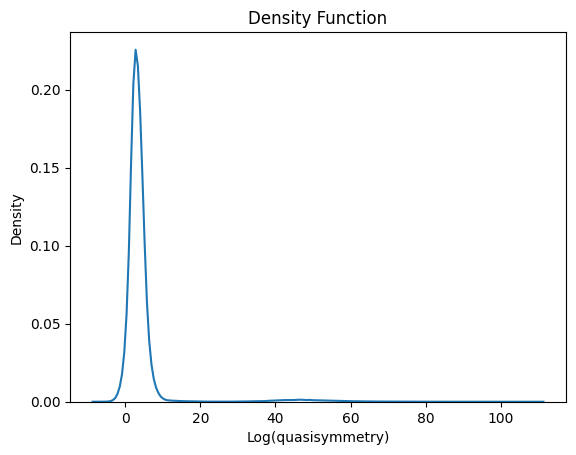

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.kdeplot(np.log(target), bw_adjust=0.5)
plt.title('Density Function')
plt.xlabel('Log(quasisymmetry)')
plt.ylabel('Density')
plt.show()


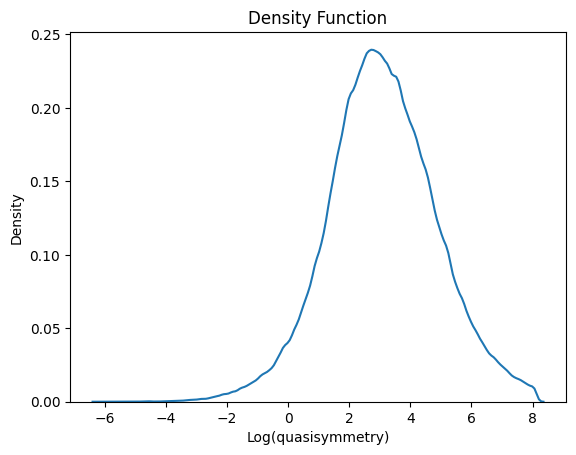

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming Y_train, X_train, Y_test, and X_test are pandas Series/DataFrames

# Calculate the IQR and bounds for outliers
q1 = Y_train.quantile(0.05)
q3 = Y_train.quantile(0.95) 
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out the outliers from Y_train
target_no_outliers = Y_train[(Y_train >= lower_bound) & (Y_train <= upper_bound)]

# Check and filter X_train based on the indices of the filtered Y_train
features_no_outliers = X_train.loc[target_no_outliers.index.intersection(X_train.index)]

# For X_test and Y_test, you need to apply a similar filter or ensure the indices match
# Assuming Y_test should be filtered using the same bounds defined by Y_train
test_target_no_outliers = Y_test[(Y_test >= lower_bound) & (Y_test <= upper_bound)]
test_features_no_outliers = X_test.loc[test_target_no_outliers.index.intersection(X_test.index)]

# Plot the KDE of log-transformed target values without outliers
sns.kdeplot(np.log(target_no_outliers), bw_adjust=0.5)
plt.title('Density Function')
plt.xlabel('Log(quasisymmetry)')
plt.ylabel('Density')
plt.show()


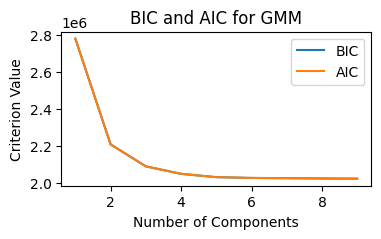

Selected Model Components: 9


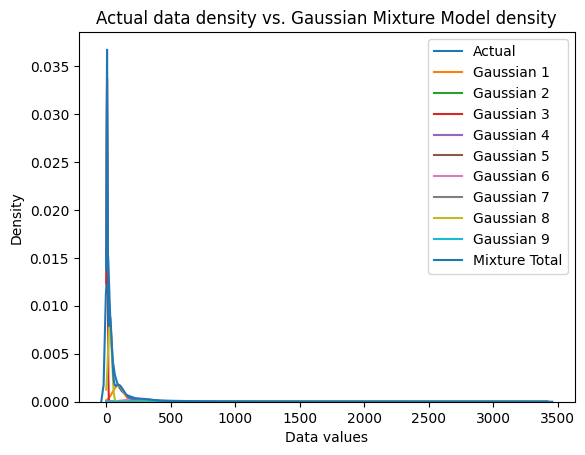

In [5]:
from sklearn.mixture import GaussianMixture

from scipy.stats import norm

X_train, X_test, Y_train, Y_test = train_test_split(features_no_outliers, target_no_outliers, test_size=0.2, random_state=42)


# Assuming `Y_train_np` is your 1D numpy array data
Y_train_np = Y_train.to_numpy().reshape(-1, 1)  # Reshape to 2D if necessary

# Use AIC and BIC to determine the best number of components for GMM
n_components_range = range(1, 10)  # Example range, can be adjusted
lowest_bic = np.infty
lowest_aic = np.infty
best_gmm = None
bic = []
aic = []

for n_components in n_components_range:
    # Fit a Gaussian mixture with n components
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(Y_train_np)
    
    # Calculate the BIC and AIC
    bic.append(gmm.bic(Y_train_np))
    aic.append(gmm.aic(Y_train_np))
    
    # Determine if this model has the lowest BIC
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm_bic = gmm
        
    # Determine if this model has the lowest AIC
    if aic[-1] < lowest_aic:
        lowest_aic = aic[-1]
        best_gmm_aic = gmm

# Plot the BIC scores
plt.figure(figsize=(4, 2))
plt.plot(n_components_range, bic, label='BIC')
plt.plot(n_components_range, aic, label='AIC')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Criterion Value')
plt.title('BIC and AIC for GMM')
plt.show()

# Use the best model for the final density plot
best_gmm = best_gmm_bic if lowest_bic < lowest_aic else best_gmm_aic
print(f"Selected Model Components: {best_gmm.n_components}")

# Generate some data points for plotting the density
x = np.linspace(Y_train_np.min(), Y_train_np.max(), 1000).reshape(-1, 1)
logprob = best_gmm.score_samples(x)
responsibilities = best_gmm.predict_proba(x)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

# Plot the actual kernel density estimation of your data
sns.kdeplot(Y_train_np.flatten(), bw_adjust=0.5, label='Actual')

# Plot each component density
for i in range(best_gmm.n_components):
    plt.plot(x, pdf_individual[:, i], label=f'Gaussian {i+1}')

# Plot the total density
plt.plot(x, pdf, label='Mixture Total')

plt.legend()
plt.title('Actual data density vs. Gaussian Mixture Model density')
plt.xlabel('Data values')
plt.ylabel('Density')
plt.show()


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fitting of candidate distributions completed: 100%|██████████| 8/8 [00:18<00:00,  2.25s/it]


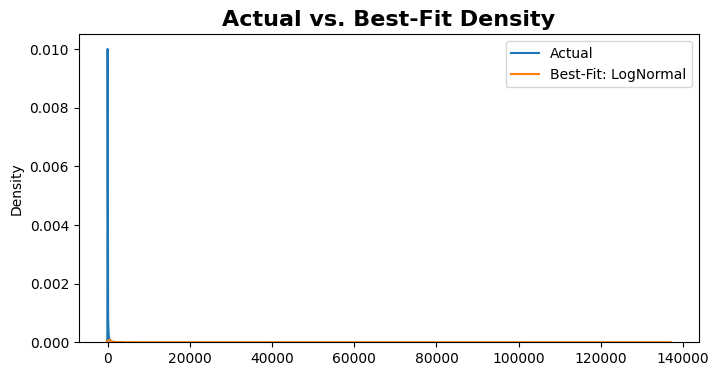

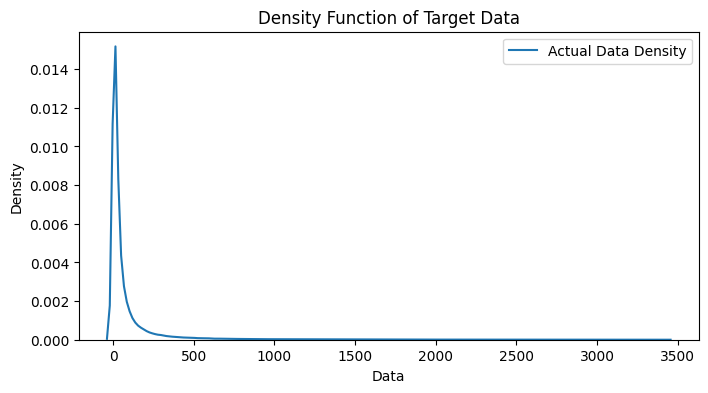

In [6]:
from lightgbmlss.distributions import *
from lightgbmlss.distributions.distribution_utils import DistributionClass
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Your data preparation steps
Y_train_np = np.array(Y_train)

lgblss_dist_class = DistributionClass()
candidate_distributions = [Gaussian, StudentT, Gamma, Cauchy, LogNormal, Weibull, Gumbel, Laplace]

# Selecting the best distribution based on negative log-likelihood
dist_nll = lgblss_dist_class.dist_select(target=Y_train_np, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(8, 4))
dist_nll

# Plot the actual data density
plt.figure(figsize=(8, 4))
sns.kdeplot(Y_train_np, bw_adjust=0.5, label='Actual Data Density')
plt.title('Density Function of Target Data')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.show()


este grafico apenas ve a distribuição da target variable?

In [20]:
import lightgbm as lgb
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from optuna.integration import LightGBMPruningCallback
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.samplers import TPESampler, CmaEsSampler
%matplotlib inline

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'mse',
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 1, 25),
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.3, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 1000)
    }

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_index, valid_index in kf.split(X_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        Y_train_fold, Y_valid_fold = Y_train.iloc[train_index], Y_train.iloc[valid_index]
        
        gbm = lgb.LGBMRegressor(**param)
        gbm.fit(X_train_fold, Y_train_fold, eval_set=[(X_valid_fold, Y_valid_fold)], eval_metric='mse',
                callbacks=[lgb.early_stopping(stopping_rounds=50)])
        preds = gbm.predict(X_valid_fold)
        mse_scores.append(mean_squared_error(Y_valid_fold, preds))
    
    return np.mean(mse_scores)

# Set TPESampler as the sampler algorithm
sampler = TPESampler()

# Create a study object and specify the optimization direction (minimize)
study = optuna.create_study(direction='minimize', sampler=sampler, pruner=optuna.pruners.MedianPruner())

# Add stream handler of stdout to show the messages
#optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

# Run the optimization with TPESampler as the sampler
study.optimize(objective, n_trials=50, gc_after_trial=True)

# Write results to a file
with open('/home/rofarate/PIC-STELLARATOR/data_analysis/optuna_trials.txt', 'w') as f:
    f.write(f"Best Parameters: {study.best_params}\n")
    f.write(f"Best Score: {study.best_value}\n")

    # Optionally, write all trial results
    for trial in study.trials:
        f.write(f"Trial {trial.number}, Value: {trial.value}, Params: {trial.params}\n")


# Access the best parameters and best score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best Score:", best_score)


[I 2024-05-07 15:17:12,613] A new study created in memory with name: no-name-de4ce2a0-93ea-4a0c-a044-9132bcc17668


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3745295367267663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745295367267663
[LightGBM] [Warning] num_iterations is set=699, num_boost_round=699 will be ignored. Current value: num_iterations=699
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3745295367267663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745295367267663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, num

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3745295367267663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745295367267663
[LightGBM] [Warning] num_iterations is set=699, num_boost_round=699 will be ignored. Current value: num_iterations=699
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3745295367267663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745295367267663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, num

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3745295367267663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745295367267663
[LightGBM] [Warning] num_iterations is set=699, num_boost_round=699 will be ignored. Current value: num_iterations=699
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3745295367267663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745295367267663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, num

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3745295367267663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745295367267663
[LightGBM] [Warning] num_iterations is set=699, num_boost_round=699 will be ignored. Current value: num_iterations=699
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3745295367267663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745295367267663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, num

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3745295367267663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745295367267663
[LightGBM] [Warning] num_iterations is set=699, num_boost_round=699 will be ignored. Current value: num_iterations=699
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3745295367267663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745295367267663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-05-07 15:17:22,431] Trial 0 finished with value: 63649.78617402967 and parameters: {'max_depth': 12, 'num_leaves': 40, 'min_data_in_leaf': 69, 'feature_fraction': 0.3745295367267663, 'learning_rate': 0.07108366931075459, 'num_boost_round': 699}. Best is trial 0 with value: 63649.78617402967.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.6694749351829322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694749351829322
[LightGBM] [Warning] num_iterations is set=344, num_boost_round=344 will be ignored. Current value: num_iterations=344
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.6694749351829322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694749351829322
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[344]	valid_0's l2: 73415.1
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.6694749351829322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694749351829322
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.6694749351829322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694749351829322
[LightGBM] [Warning] num_iterations is set=344, num_boost_round=344 will be ignored. Current value: num_iterations=344
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.6694749351829322, colsample_bytree=1.0 will be ignored. Current value: feature_fract

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[344]	valid_0's l2: 74274.7
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.6694749351829322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694749351829322
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.6694749351829322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694749351829322
[LightGBM] [Warning] num_iterations is set=344, num_boost_round=344 will be ignored. Current value: num_iterations=344
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.6694749351829322, colsample_bytree=1.0 will be ignored. Current value: feature_fract

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[344]	valid_0's l2: 73477.5
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.6694749351829322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694749351829322
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.6694749351829322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694749351829322
[LightGBM] [Warning] num_iterations is set=344, num_boost_round=344 will be ignored. Current value: num_iterations=344
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.6694749351829322, colsample_bytree=1.0 will be ignored. Current value: feature_fract

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-05-07 15:17:26,264] Trial 1 finished with value: 73807.11604672599 and parameters: {'max_depth': 24, 'num_leaves': 6, 'min_data_in_leaf': 99, 'feature_fraction': 0.6694749351829322, 'learning_rate': 0.01805284556298793, 'num_boost_round': 344}. Best is trial 0 with value: 63649.78617402967.


Did not meet early stopping. Best iteration is:
[344]	valid_0's l2: 74672.1
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.6694749351829322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694749351829322


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] feature_fraction is set=0.30105412757763894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30105412757763894
[LightGBM] [Warning] num_iterations is set=862, num_boost_round=862 will be ignored. Current value: num_iterations=862
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] feature_fraction is set=0.30105412757763894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30105412757763894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] feature_fraction is set=0.30105412757763894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30105412757763894
[LightGBM] [Warning] num_iterations is set=862, num_boost_round=862 will be ignored. Current value: num_iterations=862
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] feature_fraction is set=0.30105412757763894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30105412757763894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] feature_fraction is set=0.30105412757763894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30105412757763894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] feature_fraction is set=0.30105412757763894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30105412757763894
[LightGBM] [Warning] num_iterations is set=862, num_boost_round=862 will be ignored. Current value: num_iterations=862
[LightGBM] [Info] Start training

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] feature_fraction is set=0.30105412757763894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30105412757763894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] feature_fraction is set=0.30105412757763894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30105412757763894
[LightGBM] [Warning] num_iterations is set=862, num_boost_round=862 will be ignored. Cu

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] feature_fraction is set=0.30105412757763894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30105412757763894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] feature_fraction is set=0.30105412757763894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30105412757763894
[LightGBM] [Warning] num_iterations is set=862, num_boost_round=862 will be ignored. Cu

[I 2024-05-07 15:17:33,331] Trial 2 finished with value: 74262.64964135928 and parameters: {'max_depth': 10, 'num_leaves': 4, 'min_data_in_leaf': 113, 'feature_fraction': 0.30105412757763894, 'learning_rate': 0.03829899836723505, 'num_boost_round': 862}. Best is trial 0 with value: 63649.78617402967.


Did not meet early stopping. Best iteration is:
[862]	valid_0's l2: 74925.2
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] feature_fraction is set=0.30105412757763894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30105412757763894


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7596639254638231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7596639254638231
[LightGBM] [Warning] num_iterations is set=559, num_boost_round=559 will be ignored. Current value: num_iterations=559
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7596639254638231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7596639254638231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7596639254638231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7596639254638231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7596639254638231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7596639254638231
[LightGBM] [Warning] num_iterations is set=559, num_boost_round=559 will be ignored. Current value: num_iterations=559
[LightGBM] [Info] Start training from sc

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7596639254638231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7596639254638231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7596639254638231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7596639254638231
[LightGBM] [Warning] num_iterations is set=559, num_boost_round=559 will be ignored. Current value: num_iterations=559
[LightGBM] [Info] Start training from sc

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7596639254638231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7596639254638231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7596639254638231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7596639254638231
[LightGBM] [Warning] num_iterations is set=559, num_boost_round=559 will be ignored. Current value: num_iterations=559
[LightGBM] [Info] Start training from sc

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7596639254638231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7596639254638231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7596639254638231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7596639254638231
[LightGBM] [Warning] num_iterations is set=559, num_boost_round=559 will be ignored. Current value: num_iterations=559
[LightGBM] [Info] Start training from sc

[I 2024-05-07 15:17:40,599] Trial 3 finished with value: 55385.489020809284 and parameters: {'max_depth': 18, 'num_leaves': 32, 'min_data_in_leaf': 45, 'feature_fraction': 0.7596639254638231, 'learning_rate': 0.07117288988471918, 'num_boost_round': 559}. Best is trial 3 with value: 55385.489020809284.


Did not meet early stopping. Best iteration is:
[559]	valid_0's l2: 56434.9
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7596639254638231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7596639254638231


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] feature_fraction is set=0.6273338611804724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6273338611804724
[LightGBM] [Warning] num_iterations is set=975, num_boost_round=975 will be ignored. Current value: num_iterations=975
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] feature_fraction is set=0.6273338611804724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6273338611804724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] feature_fraction is set=0.6273338611804724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6273338611804724
[LightGBM] [Warning] num_iterations is set=975, num_boost_round=975 will be ignored. Current value: num_iterations=975
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] feature_fraction is set=0.6273338611804724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6273338611804724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] feature_fraction is set=0.6273338611804724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6273338611804724
[LightGBM] [Warning] num_iterations is set=975, num_boost_round=975 will be ignored. Current value: num_iterations=975
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] feature_fraction is set=0.6273338611804724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6273338611804724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] feature_fraction is set=0.6273338611804724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6273338611804724
[LightGBM] [Warning] num_iterations is set=975, num_boost_round=975 will be ignored. Current value: num_iterations=975
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] feature_fraction is set=0.6273338611804724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6273338611804724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] feature_fraction is set=0.6273338611804724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6273338611804724
[LightGBM] [Warning] num_iterations is set=975, num_boost_round=975 will be ignored. Current value: num_iterations=975
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] feature_fraction is set=0.6273338611804724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6273338611804724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:17:54,389] Trial 4 finished with value: 56670.97988800993 and parameters: {'max_depth': 11, 'num_leaves': 36, 'min_data_in_leaf': 171, 'feature_fraction': 0.6273338611804724, 'learning_rate': 0.042667284399786266, 'num_boost_round': 975}. Best is trial 3 with value: 55385.489020809284.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.8718403330497682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718403330497682
[LightGBM] [Warning] num_iterations is set=260, num_boost_round=260 will be ignored. Current value: num_iterations=260
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.8718403330497682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718403330497682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[260]	valid_0's l2: 59311.7
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.8718403330497682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718403330497682
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.8718403330497682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718403330497682
[LightGBM] [Warning] num_iterations is set=260, num_boost_round=260 will be ignored. Current value: num_iterations=260
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.8718403330497682, colsample_bytree=1.0 will be ignored. Current value: feature_fract

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[260]	valid_0's l2: 59599.6
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.8718403330497682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718403330497682
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.8718403330497682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718403330497682
[LightGBM] [Warning] num_iterations is set=260, num_boost_round=260 will be ignored. Current value: num_iterations=260
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.8718403330497682, colsa

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[260]	valid_0's l2: 59503
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.8718403330497682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718403330497682
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.8718403330497682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718403330497682
[LightGBM] [Warning] num_iterations is set=260, num_boost_round=260 will be ignored. Current value: num_iterations=260
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.8718403330497682, colsample_bytree=1.0 will be ignored. Current value: feature_fractio

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-05-07 15:17:59,696] Trial 5 finished with value: 59758.20411327116 and parameters: {'max_depth': 9, 'num_leaves': 35, 'min_data_in_leaf': 26, 'feature_fraction': 0.8718403330497682, 'learning_rate': 0.0450151009169071, 'num_boost_round': 260}. Best is trial 3 with value: 55385.489020809284.


Did not meet early stopping. Best iteration is:
[260]	valid_0's l2: 61136.1
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.8718403330497682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718403330497682


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.3577119632614396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3577119632614396
[LightGBM] [Warning] num_iterations is set=292, num_boost_round=292 will be ignored. Current value: num_iterations=292
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.3577119632614396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3577119632614396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[292]	valid_0's l2: 70714
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.3577119632614396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3577119632614396
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.3577119632614396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3577119632614396
[LightGBM] [Warning] num_iterations is set=292, num_boost_round=292 will be ignored. Current value: num_iterations=292
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.3577119632614396, colsample_bytree=1.0 will be ignored. Current value: feature_f

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[292]	valid_0's l2: 71459
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.3577119632614396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3577119632614396
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.3577119632614396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3577119632614396
[LightGBM] [Warning] num_iterations is set=292, num_boost_round=292 will be ignored. Current value: num_iterations=292
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.3577119632614396, colsample_bytree=1.0 will be ignored. Current value: feature_f

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[292]	valid_0's l2: 70885.7
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.3577119632614396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3577119632614396
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.3577119632614396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3577119632614396
[LightGBM] [Warning] num_iterations is set=292, num_boost_round=292 will be ignored. Current value: num_iterations=292
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.3577119632614396, colsample_bytree=1.0 will be ignored. Current value: feature

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-05-07 15:18:03,138] Trial 6 finished with value: 71079.56912506392 and parameters: {'max_depth': 18, 'num_leaves': 8, 'min_data_in_leaf': 282, 'feature_fraction': 0.3577119632614396, 'learning_rate': 0.05494746515763944, 'num_boost_round': 292}. Best is trial 3 with value: 55385.489020809284.


Did not meet early stopping. Best iteration is:
[292]	valid_0's l2: 71927.1
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.3577119632614396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3577119632614396


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8854200791892526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854200791892526
[LightGBM] [Warning] num_iterations is set=866, num_boost_round=866 will be ignored. Current value: num_iterations=866
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8854200791892526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854200791892526
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8854200791892526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854200791892526
[LightGBM] [Warning] num_iterations is set=866, num_boost_round=866 will be ignored. Current value: num_iterations=866
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8854200791892526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854200791892526
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8854200791892526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854200791892526
[LightGBM] [Warning] num_iterations is set=866, num_boost_round=866 will be ignored. Current value: num_iterations=866
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8854200791892526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854200791892526
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8854200791892526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854200791892526
[LightGBM] [Warning] num_iterations is set=866, num_boost_round=866 will be ignored. Current value: num_iterations=866
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8854200791892526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854200791892526
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8854200791892526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854200791892526
[LightGBM] [Warning] num_iterations is set=866, num_boost_round=866 will be ignored. Current value: num_iterations=866
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8854200791892526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854200791892526
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:18:14,314] Trial 7 finished with value: 52833.04574768535 and parameters: {'max_depth': 14, 'num_leaves': 32, 'min_data_in_leaf': 120, 'feature_fraction': 0.8854200791892526, 'learning_rate': 0.05170520241925209, 'num_boost_round': 866}. Best is trial 7 with value: 52833.04574768535.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=249, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=249
[LightGBM] [Warning] feature_fraction is set=0.5304507240028065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5304507240028065
[LightGBM] [Warning] num_iterations is set=623, num_boost_round=623 will be ignored. Current value: num_iterations=623
[LightGBM] [Warning] min_data_in_leaf is set=249, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=249
[LightGBM] [Warning] feature_fraction is set=0.5304507240028065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5304507240028065
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=249, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=249
[LightGBM] [Warning] feature_fraction is set=0.5304507240028065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5304507240028065
[LightGBM] [Warning] num_iterations is set=623, num_boost_round=623 will be ignored. Current value: num_iterations=623
[LightGBM] [Warning] min_data_in_leaf is set=249, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=249
[LightGBM] [Warning] feature_fraction is set=0.5304507240028065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5304507240028065
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945,

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=249, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=249
[LightGBM] [Warning] feature_fraction is set=0.5304507240028065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5304507240028065
[LightGBM] [Warning] num_iterations is set=623, num_boost_round=623 will be ignored. Current value: num_iterations=623
[LightGBM] [Warning] min_data_in_leaf is set=249, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=249
[LightGBM] [Warning] feature_fraction is set=0.5304507240028065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5304507240028065
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=249, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=249
[LightGBM] [Warning] feature_fraction is set=0.5304507240028065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5304507240028065
[LightGBM] [Warning] num_iterations is set=623, num_boost_round=623 will be ignored. Current value: num_iterations=623
[LightGBM] [Warning] min_data_in_leaf is set=249, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=249
[LightGBM] [Warning] feature_fraction is set=0.5304507240028065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5304507240028065
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=249, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=249
[LightGBM] [Warning] feature_fraction is set=0.5304507240028065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5304507240028065
[LightGBM] [Warning] num_iterations is set=623, num_boost_round=623 will be ignored. Current value: num_iterations=623
[LightGBM] [Warning] min_data_in_leaf is set=249, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=249
[LightGBM] [Warning] feature_fraction is set=0.5304507240028065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5304507240028065
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:18:25,730] Trial 8 finished with value: 62990.15035664273 and parameters: {'max_depth': 12, 'num_leaves': 50, 'min_data_in_leaf': 249, 'feature_fraction': 0.5304507240028065, 'learning_rate': 0.02683527743068953, 'num_boost_round': 623}. Best is trial 7 with value: 52833.04574768535.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.35187708059413025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35187708059413025
[LightGBM] [Warning] num_iterations is set=451, num_boost_round=451 will be ignored. Current value: num_iterations=451
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.35187708059413025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35187708059413025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.35187708059413025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35187708059413025
[LightGBM] [Warning] num_iterations is set=451, num_boost_round=451 will be ignored. Current value: num_iterations=451
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.35187708059413025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35187708059413025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.35187708059413025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35187708059413025
[LightGBM] [Warning] num_iterations is set=451, num_boost_round=451 will be ignored. Current value: num_iterations=451
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.35187708059413025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35187708059413025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945,

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.35187708059413025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35187708059413025
[LightGBM] [Warning] num_iterations is set=451, num_boost_round=451 will be ignored. Current value: num_iterations=451
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.35187708059413025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35187708059413025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.35187708059413025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35187708059413025
[LightGBM] [Warning] num_iterations is set=451, num_boost_round=451 will be ignored. Current value: num_iterations=451
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.35187708059413025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35187708059413025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:18:33,114] Trial 9 finished with value: 65949.95393258998 and parameters: {'max_depth': 11, 'num_leaves': 47, 'min_data_in_leaf': 81, 'feature_fraction': 0.35187708059413025, 'learning_rate': 0.03186633934881531, 'num_boost_round': 451}. Best is trial 7 with value: 52833.04574768535.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=179, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=179
[LightGBM] [Warning] feature_fraction is set=0.9945993155386774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9945993155386774
[LightGBM] [Warning] num_iterations is set=782, num_boost_round=782 will be ignored. Current value: num_iterations=782
[LightGBM] [Warning] min_data_in_leaf is set=179, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=179
[LightGBM] [Warning] feature_fraction is set=0.9945993155386774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9945993155386774
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[782]	valid_0's l2: 78464.1
[LightGBM] [Warning] min_data_in_leaf is set=179, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=179
[LightGBM] [Warning] feature_fraction is set=0.9945993155386774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9945993155386774
[LightGBM] [Warning] min_data_in_leaf is set=179, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=179
[LightGBM] [Warning] feature_fraction is set=0.9945993155386774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9945993155386774
[LightGBM] [Warning] num_iterations is set=782, num_boost_round=782 will be ignored. Current value: num_iterations=782
[LightGBM] [Warning] min_data_in_leaf is set=179, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=179
[LightGBM] [Warning] feature_fraction is set=0.9945993155386774, colsample_bytree=1.0 will be ignored. Current value: feature

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[782]	valid_0's l2: 79443.7
[LightGBM] [Warning] min_data_in_leaf is set=179, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=179
[LightGBM] [Warning] feature_fraction is set=0.9945993155386774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9945993155386774
[LightGBM] [Warning] min_data_in_leaf is set=179, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=179
[LightGBM] [Warning] feature_fraction is set=0.9945993155386774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9945993155386774
[LightGBM] [Warning] num_iterations is set=782, num_boost_round=782 will be ignored. Current value: num_iterations=782
[LightGBM] [Warning] min_data_in_leaf is set=179, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=179
[LightGBM] [Warning] feature_fraction is set=0.9945993155386774, colsample_bytree=1.0 will be ignored. Current value: feature

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[782]	valid_0's l2: 78353.5
[LightGBM] [Warning] min_data_in_leaf is set=179, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=179
[LightGBM] [Warning] feature_fraction is set=0.9945993155386774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9945993155386774
[LightGBM] [Warning] min_data_in_leaf is set=179, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=179
[LightGBM] [Warning] feature_fraction is set=0.9945993155386774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9945993155386774
[LightGBM] [Warning] num_iterations is set=782, num_boost_round=782 will be ignored. Current value: num_iterations=782
[LightGBM] [Warning] min_data_in_leaf is set=179, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=179
[LightGBM] [Warning] feature_fraction is set=0.9945993155386774, colsample_bytree=1.0 will be ignored. Current value: feature

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-05-07 15:18:37,604] Trial 10 finished with value: 78764.04340446347 and parameters: {'max_depth': 1, 'num_leaves': 19, 'min_data_in_leaf': 179, 'feature_fraction': 0.9945993155386774, 'learning_rate': 0.010255456514021558, 'num_boost_round': 782}. Best is trial 7 with value: 52833.04574768535.


Did not meet early stopping. Best iteration is:
[782]	valid_0's l2: 79241.9
[LightGBM] [Warning] min_data_in_leaf is set=179, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=179
[LightGBM] [Warning] feature_fraction is set=0.9945993155386774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9945993155386774


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.8108737546310395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8108737546310395
[LightGBM] [Warning] num_iterations is set=520, num_boost_round=520 will be ignored. Current value: num_iterations=520
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.8108737546310395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8108737546310395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Start training from score 102.124746
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[520]	valid_0's l2: 55831.7
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.8108737546310395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8108737546310395
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.8108737546310395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8108737546310395
[LightGBM] [Warning] num_iterations is set=520, num_boost_round=520 will be ignored. Current value: num_iterations=520
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [War

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.8108737546310395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8108737546310395
[LightGBM] [Warning] num_iterations is set=520, num_boost_round=520 will be ignored. Current value: num_iterations=520
[LightGBM] [Info] Start training from score 102.072253
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[520]	valid_0's l2: 56390
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[Lig

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Start training from score 102.150508
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[520]	valid_0's l2: 55857.2
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.8108737546310395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8108737546310395
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.8108737546310395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8108737546310395
[LightGBM] [Warning] num_iterations is set=520, num_boost_round=520 will be ignored. Current value: num_iterations=520
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [War

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.8108737546310395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8108737546310395
[LightGBM] [Warning] num_iterations is set=520, num_boost_round=520 will be ignored. Current value: num_iterations=520
[LightGBM] [Info] Start training from score 102.073717
Training until validation scores don't improve for 50 rounds


[I 2024-05-07 15:18:43,049] Trial 11 finished with value: 56361.80365151945 and parameters: {'max_depth': 18, 'num_leaves': 23, 'min_data_in_leaf': 34, 'feature_fraction': 0.8108737546310395, 'learning_rate': 0.09990486568648485, 'num_boost_round': 520}. Best is trial 7 with value: 52833.04574768535.


Did not meet early stopping. Best iteration is:
[520]	valid_0's l2: 57834.4
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.8108737546310395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8108737546310395


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.8116081007346043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8116081007346043
[LightGBM] [Warning] num_iterations is set=965, num_boost_round=965 will be ignored. Current value: num_iterations=965
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.8116081007346043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8116081007346043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.8116081007346043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8116081007346043
[LightGBM] [Warning] num_iterations is set=965, num_boost_round=965 will be ignored. Current value: num_iterations=965
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.8116081007346043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8116081007346043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.8116081007346043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8116081007346043
[LightGBM] [Warning] num_iterations is set=965, num_boost_round=965 will be ignored. Current value: num_iterations=965
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.8116081007346043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8116081007346043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.8116081007346043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8116081007346043
[LightGBM] [Warning] num_iterations is set=965, num_boost_round=965 will be ignored. Current value: num_iterations=965
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.8116081007346043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8116081007346043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.8116081007346043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8116081007346043
[LightGBM] [Warning] num_iterations is set=965, num_boost_round=965 will be ignored. Current value: num_iterations=965
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.8116081007346043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8116081007346043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:18:53,962] Trial 12 finished with value: 53263.87217493468 and parameters: {'max_depth': 18, 'num_leaves': 30, 'min_data_in_leaf': 132, 'feature_fraction': 0.8116081007346043, 'learning_rate': 0.07261312467867134, 'num_boost_round': 965}. Best is trial 7 with value: 52833.04574768535.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] feature_fraction is set=0.9741945118884516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9741945118884516
[LightGBM] [Warning] num_iterations is set=948, num_boost_round=948 will be ignored. Current value: num_iterations=948
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] feature_fraction is set=0.9741945118884516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9741945118884516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] feature_fraction is set=0.9741945118884516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9741945118884516
[LightGBM] [Warning] num_iterations is set=948, num_boost_round=948 will be ignored. Current value: num_iterations=948
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] feature_fraction is set=0.9741945118884516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9741945118884516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] feature_fraction is set=0.9741945118884516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9741945118884516
[LightGBM] [Warning] num_iterations is set=948, num_boost_round=948 will be ignored. Current value: num_iterations=948
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] feature_fraction is set=0.9741945118884516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9741945118884516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] feature_fraction is set=0.9741945118884516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9741945118884516
[LightGBM] [Warning] num_iterations is set=948, num_boost_round=948 will be ignored. Current value: num_iterations=948
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] feature_fraction is set=0.9741945118884516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9741945118884516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] feature_fraction is set=0.9741945118884516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9741945118884516
[LightGBM] [Warning] num_iterations is set=948, num_boost_round=948 will be ignored. Current value: num_iterations=948
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] feature_fraction is set=0.9741945118884516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9741945118884516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:19:04,232] Trial 13 finished with value: 49879.24992356453 and parameters: {'max_depth': 23, 'num_leaves': 27, 'min_data_in_leaf': 146, 'feature_fraction': 0.9741945118884516, 'learning_rate': 0.0991369634673417, 'num_boost_round': 948}. Best is trial 13 with value: 49879.24992356453.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9931375615830396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9931375615830396
[LightGBM] [Warning] num_iterations is set=861, num_boost_round=861 will be ignored. Current value: num_iterations=861
[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9931375615830396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9931375615830396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9931375615830396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9931375615830396
[LightGBM] [Warning] num_iterations is set=861, num_boost_round=861 will be ignored. Current value: num_iterations=861
[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9931375615830396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9931375615830396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9931375615830396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9931375615830396
[LightGBM] [Warning] num_iterations is set=861, num_boost_round=861 will be ignored. Current value: num_iterations=861
[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9931375615830396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9931375615830396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9931375615830396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9931375615830396
[LightGBM] [Warning] num_iterations is set=861, num_boost_round=861 will be ignored. Current value: num_iterations=861
[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9931375615830396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9931375615830396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9931375615830396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9931375615830396
[LightGBM] [Warning] num_iterations is set=861, num_boost_round=861 will be ignored. Current value: num_iterations=861
[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9931375615830396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9931375615830396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:19:13,499] Trial 14 finished with value: 52310.61235989729 and parameters: {'max_depth': 24, 'num_leaves': 20, 'min_data_in_leaf': 209, 'feature_fraction': 0.9931375615830396, 'learning_rate': 0.09753222270150419, 'num_boost_round': 861}. Best is trial 13 with value: 49879.24992356453.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222
[LightGBM] [Warning] feature_fraction is set=0.9821242084698678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9821242084698678
[LightGBM] [Warning] num_iterations is set=763, num_boost_round=763 will be ignored. Current value: num_iterations=763
[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222
[LightGBM] [Warning] feature_fraction is set=0.9821242084698678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9821242084698678
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944,

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222
[LightGBM] [Warning] feature_fraction is set=0.9821242084698678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9821242084698678
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222
[LightGBM] [Warning] feature_fraction is set=0.9821242084698678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9821242084698678
[LightGBM] [Warning] num_iterations is set=763, num_boost_round=763 will be ignored. Current value: num_iterations=763
[LightGBM] [Info] Start training fro

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222
[LightGBM] [Warning] feature_fraction is set=0.9821242084698678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9821242084698678
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222
[LightGBM] [Warning] feature_fraction is set=0.9821242084698678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9821242084698678
[LightGBM] [Warning] num_iterations is set=763, num_boost_round=763 will be ignored. Current value: num_iterations=763
[LightGBM] [Info] Start training fro

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222
[LightGBM] [Warning] feature_fraction is set=0.9821242084698678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9821242084698678
[LightGBM] [Warning] num_iterations is set=763, num_boost_round=763 will be ignored. Current value: num_iterations=763
[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222
[LightGBM] [Warning] feature_fraction is set=0.9821242084698678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9821242084698678
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222
[LightGBM] [Warning] feature_fraction is set=0.9821242084698678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9821242084698678
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222
[LightGBM] [Warning] feature_fraction is set=0.9821242084698678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9821242084698678
[LightGBM] [Warning] num_iterations is set=763, num_boost_round=763 will be ignored. Current value: num_iterations=763
[LightGBM] [Info] Start training fro

[I 2024-05-07 15:19:21,154] Trial 15 finished with value: 55241.11038795373 and parameters: {'max_depth': 25, 'num_leaves': 15, 'min_data_in_leaf': 222, 'feature_fraction': 0.9821242084698678, 'learning_rate': 0.09828243711612274, 'num_boost_round': 763}. Best is trial 13 with value: 49879.24992356453.


Did not meet early stopping. Best iteration is:
[763]	valid_0's l2: 56168.5
[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222
[LightGBM] [Warning] feature_fraction is set=0.9821242084698678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9821242084698678


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9342505522364374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9342505522364374
[LightGBM] [Warning] num_iterations is set=995, num_boost_round=995 will be ignored. Current value: num_iterations=995
[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9342505522364374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9342505522364374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9342505522364374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9342505522364374
[LightGBM] [Warning] num_iterations is set=995, num_boost_round=995 will be ignored. Current value: num_iterations=995
[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9342505522364374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9342505522364374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9342505522364374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9342505522364374
[LightGBM] [Warning] num_iterations is set=995, num_boost_round=995 will be ignored. Current value: num_iterations=995
[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9342505522364374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9342505522364374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9342505522364374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9342505522364374
[LightGBM] [Warning] num_iterations is set=995, num_boost_round=995 will be ignored. Current value: num_iterations=995
[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9342505522364374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9342505522364374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9342505522364374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9342505522364374
[LightGBM] [Warning] num_iterations is set=995, num_boost_round=995 will be ignored. Current value: num_iterations=995
[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] feature_fraction is set=0.9342505522364374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9342505522364374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:19:33,536] Trial 16 finished with value: 59658.55041936773 and parameters: {'max_depth': 22, 'num_leaves': 24, 'min_data_in_leaf': 209, 'feature_fraction': 0.9342505522364374, 'learning_rate': 0.01920289504981468, 'num_boost_round': 995}. Best is trial 13 with value: 49879.24992356453.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.7022386235740969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7022386235740969
[LightGBM] [Warning] num_iterations is set=858, num_boost_round=858 will be ignored. Current value: num_iterations=858
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.7022386235740969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7022386235740969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.7022386235740969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7022386235740969
[LightGBM] [Warning] num_iterations is set=858, num_boost_round=858 will be ignored. Current value: num_iterations=858
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.7022386235740969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7022386235740969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.7022386235740969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7022386235740969
[LightGBM] [Warning] num_iterations is set=858, num_boost_round=858 will be ignored. Current value: num_iterations=858
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.7022386235740969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7022386235740969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.7022386235740969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7022386235740969
[LightGBM] [Warning] num_iterations is set=858, num_boost_round=858 will be ignored. Current value: num_iterations=858
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.7022386235740969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7022386235740969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.7022386235740969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7022386235740969
[LightGBM] [Warning] num_iterations is set=858, num_boost_round=858 will be ignored. Current value: num_iterations=858
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.7022386235740969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7022386235740969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:19:41,746] Trial 17 finished with value: 57960.85655972168 and parameters: {'max_depth': 21, 'num_leaves': 14, 'min_data_in_leaf': 160, 'feature_fraction': 0.7022386235740969, 'learning_rate': 0.08223752150271749, 'num_boost_round': 858}. Best is trial 13 with value: 49879.24992356453.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=296, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=296
[LightGBM] [Warning] feature_fraction is set=0.5410987223198263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5410987223198263
[LightGBM] [Warning] num_iterations is set=166, num_boost_round=166 will be ignored. Current value: num_iterations=166
[LightGBM] [Warning] min_data_in_leaf is set=296, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=296
[LightGBM] [Warning] feature_fraction is set=0.5410987223198263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5410987223198263
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944,

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[166]	valid_0's l2: 69387.1
[LightGBM] [Warning] min_data_in_leaf is set=296, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=296
[LightGBM] [Warning] feature_fraction is set=0.5410987223198263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5410987223198263
[LightGBM] [Warning] min_data_in_leaf is set=296, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=296
[LightGBM] [Warning] feature_fraction is set=0.5410987223198263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5410987223198263
[LightGBM] [Warning] num_iterations is set=166, num_boost_round=166 will be ignored. Current value: num_iterations=166
[LightGBM] [Warning] min_data_in_leaf is set=296, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=296
[LightGBM] [Warning] feature_fraction is set=0.5410987223198263, colsample_bytree=1.0 will be ignored. Current value: feature

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[166]	valid_0's l2: 70310.7
[LightGBM] [Warning] min_data_in_leaf is set=296, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=296
[LightGBM] [Warning] feature_fraction is set=0.5410987223198263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5410987223198263
[LightGBM] [Warning] min_data_in_leaf is set=296, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=296
[LightGBM] [Warning] feature_fraction is set=0.5410987223198263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5410987223198263
[LightGBM] [Warning] num_iterations is set=166, num_boost_round=166 will be ignored. Current value: num_iterations=166
[LightGBM] [Warning] min_data_in_leaf is set=296, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=296
[LightGBM] [Warning] feature_fraction is set=0.5410987223198263, colsample_bytree=1.0 will be ignored. Current value: feature

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[166]	valid_0's l2: 69750
[LightGBM] [Warning] min_data_in_leaf is set=296, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=296
[LightGBM] [Warning] feature_fraction is set=0.5410987223198263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5410987223198263
[LightGBM] [Warning] min_data_in_leaf is set=296, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=296
[LightGBM] [Warning] feature_fraction is set=0.5410987223198263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5410987223198263
[LightGBM] [Warning] num_iterations is set=166, num_boost_round=166 will be ignored. Current value: num_iterations=166
[LightGBM] [Warning] min_data_in_leaf is set=296, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=296
[LightGBM] [Warning] feature_fraction is set=0.5410987223198263, colsample_bytree=1.0 will be ignored. Current value: feature_f

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-05-07 15:19:44,162] Trial 18 finished with value: 69923.57637642857 and parameters: {'max_depth': 6, 'num_leaves': 13, 'min_data_in_leaf': 296, 'feature_fraction': 0.5410987223198263, 'learning_rate': 0.05825800356090893, 'num_boost_round': 166}. Best is trial 13 with value: 49879.24992356453.


Did not meet early stopping. Best iteration is:
[166]	valid_0's l2: 70830.8
[LightGBM] [Warning] min_data_in_leaf is set=296, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=296
[LightGBM] [Warning] feature_fraction is set=0.5410987223198263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5410987223198263


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=215
[LightGBM] [Warning] feature_fraction is set=0.904235038188552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.904235038188552
[LightGBM] [Warning] num_iterations is set=663, num_boost_round=663 will be ignored. Current value: num_iterations=663
[LightGBM] [Warning] min_data_in_leaf is set=215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=215
[LightGBM] [Warning] feature_fraction is set=0.904235038188552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.904235038188552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=215
[LightGBM] [Warning] feature_fraction is set=0.904235038188552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.904235038188552
[LightGBM] [Warning] num_iterations is set=663, num_boost_round=663 will be ignored. Current value: num_iterations=663
[LightGBM] [Warning] min_data_in_leaf is set=215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=215
[LightGBM] [Warning] feature_fraction is set=0.904235038188552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.904235038188552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=215
[LightGBM] [Warning] feature_fraction is set=0.904235038188552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.904235038188552
[LightGBM] [Warning] num_iterations is set=663, num_boost_round=663 will be ignored. Current value: num_iterations=663
[LightGBM] [Warning] min_data_in_leaf is set=215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=215
[LightGBM] [Warning] feature_fraction is set=0.904235038188552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.904235038188552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=215
[LightGBM] [Warning] feature_fraction is set=0.904235038188552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.904235038188552
[LightGBM] [Warning] num_iterations is set=663, num_boost_round=663 will be ignored. Current value: num_iterations=663
[LightGBM] [Warning] min_data_in_leaf is set=215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=215
[LightGBM] [Warning] feature_fraction is set=0.904235038188552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.904235038188552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=215
[LightGBM] [Warning] feature_fraction is set=0.904235038188552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.904235038188552
[LightGBM] [Warning] num_iterations is set=663, num_boost_round=663 will be ignored. Current value: num_iterations=663
[LightGBM] [Warning] min_data_in_leaf is set=215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=215
[LightGBM] [Warning] feature_fraction is set=0.904235038188552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.904235038188552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-05-07 15:19:53,280] Trial 19 finished with value: 65001.87937824719 and parameters: {'max_depth': 21, 'num_leaves': 20, 'min_data_in_leaf': 215, 'feature_fraction': 0.904235038188552, 'learning_rate': 0.010834474304468834, 'num_boost_round': 663}. Best is trial 13 with value: 49879.24992356453.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8226594927041024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8226594927041024
[LightGBM] [Warning] num_iterations is set=785, num_boost_round=785 will be ignored. Current value: num_iterations=785
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8226594927041024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8226594927041024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8226594927041024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8226594927041024
[LightGBM] [Warning] num_iterations is set=785, num_boost_round=785 will be ignored. Current value: num_iterations=785
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8226594927041024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8226594927041024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8226594927041024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8226594927041024
[LightGBM] [Warning] num_iterations is set=785, num_boost_round=785 will be ignored. Current value: num_iterations=785
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8226594927041024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8226594927041024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8226594927041024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8226594927041024
[LightGBM] [Warning] num_iterations is set=785, num_boost_round=785 will be ignored. Current value: num_iterations=785
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8226594927041024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8226594927041024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8226594927041024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8226594927041024
[LightGBM] [Warning] num_iterations is set=785, num_boost_round=785 will be ignored. Current value: num_iterations=785
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8226594927041024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8226594927041024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:20:02,557] Trial 20 finished with value: 52325.6531595098 and parameters: {'max_depth': 15, 'num_leaves': 28, 'min_data_in_leaf': 149, 'feature_fraction': 0.8226594927041024, 'learning_rate': 0.08332844052516633, 'num_boost_round': 785}. Best is trial 13 with value: 49879.24992356453.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.9427634445851973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9427634445851973
[LightGBM] [Warning] num_iterations is set=766, num_boost_round=766 will be ignored. Current value: num_iterations=766
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.9427634445851973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9427634445851973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.9427634445851973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9427634445851973
[LightGBM] [Warning] num_iterations is set=766, num_boost_round=766 will be ignored. Current value: num_iterations=766
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.9427634445851973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9427634445851973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.9427634445851973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9427634445851973
[LightGBM] [Warning] num_iterations is set=766, num_boost_round=766 will be ignored. Current value: num_iterations=766
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.9427634445851973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9427634445851973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.9427634445851973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9427634445851973
[LightGBM] [Warning] num_iterations is set=766, num_boost_round=766 will be ignored. Current value: num_iterations=766
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.9427634445851973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9427634445851973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.9427634445851973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9427634445851973
[LightGBM] [Warning] num_iterations is set=766, num_boost_round=766 will be ignored. Current value: num_iterations=766
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.9427634445851973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9427634445851973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:20:11,465] Trial 21 finished with value: 51058.30108177658 and parameters: {'max_depth': 23, 'num_leaves': 29, 'min_data_in_leaf': 148, 'feature_fraction': 0.9427634445851973, 'learning_rate': 0.08635406269590767, 'num_boost_round': 766}. Best is trial 13 with value: 49879.24992356453.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=194, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=194
[LightGBM] [Warning] feature_fraction is set=0.960283631918127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.960283631918127
[LightGBM] [Warning] num_iterations is set=903, num_boost_round=903 will be ignored. Current value: num_iterations=903
[LightGBM] [Warning] min_data_in_leaf is set=194, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=194
[LightGBM] [Warning] feature_fraction is set=0.960283631918127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.960283631918127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=194, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=194
[LightGBM] [Warning] feature_fraction is set=0.960283631918127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.960283631918127
[LightGBM] [Warning] num_iterations is set=903, num_boost_round=903 will be ignored. Current value: num_iterations=903
[LightGBM] [Warning] min_data_in_leaf is set=194, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=194
[LightGBM] [Warning] feature_fraction is set=0.960283631918127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.960283631918127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=194, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=194
[LightGBM] [Warning] feature_fraction is set=0.960283631918127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.960283631918127
[LightGBM] [Warning] num_iterations is set=903, num_boost_round=903 will be ignored. Current value: num_iterations=903
[LightGBM] [Warning] min_data_in_leaf is set=194, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=194
[LightGBM] [Warning] feature_fraction is set=0.960283631918127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.960283631918127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=194, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=194
[LightGBM] [Warning] feature_fraction is set=0.960283631918127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.960283631918127
[LightGBM] [Warning] num_iterations is set=903, num_boost_round=903 will be ignored. Current value: num_iterations=903
[LightGBM] [Warning] min_data_in_leaf is set=194, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=194
[LightGBM] [Warning] feature_fraction is set=0.960283631918127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.960283631918127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=194, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=194
[LightGBM] [Warning] feature_fraction is set=0.960283631918127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.960283631918127
[LightGBM] [Warning] num_iterations is set=903, num_boost_round=903 will be ignored. Current value: num_iterations=903
[LightGBM] [Warning] min_data_in_leaf is set=194, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=194
[LightGBM] [Warning] feature_fraction is set=0.960283631918127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.960283631918127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-05-07 15:20:23,712] Trial 22 finished with value: 48880.682496995185 and parameters: {'max_depth': 23, 'num_leaves': 41, 'min_data_in_leaf': 194, 'feature_fraction': 0.960283631918127, 'learning_rate': 0.08662182894959078, 'num_boost_round': 903}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=187, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=187
[LightGBM] [Warning] feature_fraction is set=0.9210182910487401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9210182910487401
[LightGBM] [Warning] num_iterations is set=925, num_boost_round=925 will be ignored. Current value: num_iterations=925
[LightGBM] [Warning] min_data_in_leaf is set=187, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=187
[LightGBM] [Warning] feature_fraction is set=0.9210182910487401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9210182910487401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=187, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=187
[LightGBM] [Warning] feature_fraction is set=0.9210182910487401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9210182910487401
[LightGBM] [Warning] num_iterations is set=925, num_boost_round=925 will be ignored. Current value: num_iterations=925
[LightGBM] [Warning] min_data_in_leaf is set=187, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=187
[LightGBM] [Warning] feature_fraction is set=0.9210182910487401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9210182910487401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=187, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=187
[LightGBM] [Warning] feature_fraction is set=0.9210182910487401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9210182910487401
[LightGBM] [Warning] num_iterations is set=925, num_boost_round=925 will be ignored. Current value: num_iterations=925
[LightGBM] [Warning] min_data_in_leaf is set=187, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=187
[LightGBM] [Warning] feature_fraction is set=0.9210182910487401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9210182910487401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=187, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=187
[LightGBM] [Warning] feature_fraction is set=0.9210182910487401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9210182910487401
[LightGBM] [Warning] num_iterations is set=925, num_boost_round=925 will be ignored. Current value: num_iterations=925
[LightGBM] [Warning] min_data_in_leaf is set=187, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=187
[LightGBM] [Warning] feature_fraction is set=0.9210182910487401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9210182910487401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=187, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=187
[LightGBM] [Warning] feature_fraction is set=0.9210182910487401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9210182910487401
[LightGBM] [Warning] num_iterations is set=925, num_boost_round=925 will be ignored. Current value: num_iterations=925
[LightGBM] [Warning] min_data_in_leaf is set=187, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=187
[LightGBM] [Warning] feature_fraction is set=0.9210182910487401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9210182910487401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:20:35,584] Trial 23 finished with value: 50879.17819943889 and parameters: {'max_depth': 22, 'num_leaves': 39, 'min_data_in_leaf': 187, 'feature_fraction': 0.9210182910487401, 'learning_rate': 0.06575824141166468, 'num_boost_round': 925}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] feature_fraction is set=0.8781193332705494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8781193332705494
[LightGBM] [Warning] num_iterations is set=920, num_boost_round=920 will be ignored. Current value: num_iterations=920
[LightGBM] [Warning] min_data_in_leaf is set=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] feature_fraction is set=0.8781193332705494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8781193332705494
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944,

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] feature_fraction is set=0.8781193332705494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8781193332705494
[LightGBM] [Warning] num_iterations is set=920, num_boost_round=920 will be ignored. Current value: num_iterations=920
[LightGBM] [Warning] min_data_in_leaf is set=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] feature_fraction is set=0.8781193332705494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8781193332705494
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] feature_fraction is set=0.8781193332705494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8781193332705494
[LightGBM] [Warning] num_iterations is set=920, num_boost_round=920 will be ignored. Current value: num_iterations=920
[LightGBM] [Warning] min_data_in_leaf is set=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] feature_fraction is set=0.8781193332705494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8781193332705494
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] feature_fraction is set=0.8781193332705494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8781193332705494
[LightGBM] [Warning] num_iterations is set=920, num_boost_round=920 will be ignored. Current value: num_iterations=920
[LightGBM] [Warning] min_data_in_leaf is set=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] feature_fraction is set=0.8781193332705494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8781193332705494
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] feature_fraction is set=0.8781193332705494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8781193332705494
[LightGBM] [Warning] num_iterations is set=920, num_boost_round=920 will be ignored. Current value: num_iterations=920
[LightGBM] [Warning] min_data_in_leaf is set=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] feature_fraction is set=0.8781193332705494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8781193332705494
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:20:48,834] Trial 24 finished with value: 50783.211360417314 and parameters: {'max_depth': 21, 'num_leaves': 42, 'min_data_in_leaf': 246, 'feature_fraction': 0.8781193332705494, 'learning_rate': 0.06426429173622861, 'num_boost_round': 920}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=263, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=263
[LightGBM] [Warning] feature_fraction is set=0.8509691129562387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8509691129562387
[LightGBM] [Warning] num_iterations is set=914, num_boost_round=914 will be ignored. Current value: num_iterations=914
[LightGBM] [Warning] min_data_in_leaf is set=263, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=263
[LightGBM] [Warning] feature_fraction is set=0.8509691129562387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8509691129562387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=263, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=263
[LightGBM] [Warning] feature_fraction is set=0.8509691129562387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8509691129562387
[LightGBM] [Warning] num_iterations is set=914, num_boost_round=914 will be ignored. Current value: num_iterations=914
[LightGBM] [Warning] min_data_in_leaf is set=263, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=263
[LightGBM] [Warning] feature_fraction is set=0.8509691129562387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8509691129562387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=263, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=263
[LightGBM] [Warning] feature_fraction is set=0.8509691129562387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8509691129562387
[LightGBM] [Warning] num_iterations is set=914, num_boost_round=914 will be ignored. Current value: num_iterations=914
[LightGBM] [Warning] min_data_in_leaf is set=263, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=263
[LightGBM] [Warning] feature_fraction is set=0.8509691129562387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8509691129562387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=263, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=263
[LightGBM] [Warning] feature_fraction is set=0.8509691129562387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8509691129562387
[LightGBM] [Warning] num_iterations is set=914, num_boost_round=914 will be ignored. Current value: num_iterations=914
[LightGBM] [Warning] min_data_in_leaf is set=263, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=263
[LightGBM] [Warning] feature_fraction is set=0.8509691129562387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8509691129562387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=263, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=263
[LightGBM] [Warning] feature_fraction is set=0.8509691129562387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8509691129562387
[LightGBM] [Warning] num_iterations is set=914, num_boost_round=914 will be ignored. Current value: num_iterations=914
[LightGBM] [Warning] min_data_in_leaf is set=263, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=263
[LightGBM] [Warning] feature_fraction is set=0.8509691129562387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8509691129562387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:21:02,512] Trial 25 finished with value: 50799.64148336633 and parameters: {'max_depth': 20, 'num_leaves': 43, 'min_data_in_leaf': 263, 'feature_fraction': 0.8509691129562387, 'learning_rate': 0.06171909529999786, 'num_boost_round': 914}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=235, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=235
[LightGBM] [Warning] feature_fraction is set=0.7563216112957525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563216112957525
[LightGBM] [Warning] num_iterations is set=718, num_boost_round=718 will be ignored. Current value: num_iterations=718
[LightGBM] [Warning] min_data_in_leaf is set=235, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=235
[LightGBM] [Warning] feature_fraction is set=0.7563216112957525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563216112957525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=235, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=235
[LightGBM] [Warning] feature_fraction is set=0.7563216112957525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563216112957525
[LightGBM] [Warning] num_iterations is set=718, num_boost_round=718 will be ignored. Current value: num_iterations=718
[LightGBM] [Warning] min_data_in_leaf is set=235, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=235
[LightGBM] [Warning] feature_fraction is set=0.7563216112957525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563216112957525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=235, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=235
[LightGBM] [Warning] feature_fraction is set=0.7563216112957525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563216112957525
[LightGBM] [Warning] num_iterations is set=718, num_boost_round=718 will be ignored. Current value: num_iterations=718
[LightGBM] [Warning] min_data_in_leaf is set=235, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=235
[LightGBM] [Warning] feature_fraction is set=0.7563216112957525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563216112957525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=235, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=235
[LightGBM] [Warning] feature_fraction is set=0.7563216112957525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563216112957525
[LightGBM] [Warning] num_iterations is set=718, num_boost_round=718 will be ignored. Current value: num_iterations=718
[LightGBM] [Warning] min_data_in_leaf is set=235, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=235
[LightGBM] [Warning] feature_fraction is set=0.7563216112957525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563216112957525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=235, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=235
[LightGBM] [Warning] feature_fraction is set=0.7563216112957525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563216112957525
[LightGBM] [Warning] num_iterations is set=718, num_boost_round=718 will be ignored. Current value: num_iterations=718
[LightGBM] [Warning] min_data_in_leaf is set=235, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=235
[LightGBM] [Warning] feature_fraction is set=0.7563216112957525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563216112957525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:21:13,411] Trial 26 finished with value: 52622.30076824497 and parameters: {'max_depth': 16, 'num_leaves': 43, 'min_data_in_leaf': 235, 'feature_fraction': 0.7563216112957525, 'learning_rate': 0.07941576487811496, 'num_boost_round': 718}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7546842506706282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7546842506706282
[LightGBM] [Warning] num_iterations is set=915, num_boost_round=915 will be ignored. Current value: num_iterations=915
[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7546842506706282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7546842506706282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7546842506706282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7546842506706282
[LightGBM] [Warning] num_iterations is set=915, num_boost_round=915 will be ignored. Current value: num_iterations=915
[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7546842506706282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7546842506706282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7546842506706282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7546842506706282
[LightGBM] [Warning] num_iterations is set=915, num_boost_round=915 will be ignored. Current value: num_iterations=915
[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7546842506706282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7546842506706282
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945,

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7546842506706282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7546842506706282
[LightGBM] [Warning] num_iterations is set=915, num_boost_round=915 will be ignored. Current value: num_iterations=915
[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7546842506706282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7546842506706282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7546842506706282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7546842506706282
[LightGBM] [Warning] num_iterations is set=915, num_boost_round=915 will be ignored. Current value: num_iterations=915
[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7546842506706282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7546842506706282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:21:29,006] Trial 27 finished with value: 53180.279152528245 and parameters: {'max_depth': 25, 'num_leaves': 46, 'min_data_in_leaf': 188, 'feature_fraction': 0.7546842506706282, 'learning_rate': 0.04842867802528099, 'num_boost_round': 915}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=264
[LightGBM] [Warning] feature_fraction is set=0.938257345377329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.938257345377329
[LightGBM] [Warning] num_iterations is set=813, num_boost_round=813 will be ignored. Current value: num_iterations=813
[LightGBM] [Warning] min_data_in_leaf is set=264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=264
[LightGBM] [Warning] feature_fraction is set=0.938257345377329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.938257345377329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=264
[LightGBM] [Warning] feature_fraction is set=0.938257345377329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.938257345377329
[LightGBM] [Warning] num_iterations is set=813, num_boost_round=813 will be ignored. Current value: num_iterations=813
[LightGBM] [Warning] min_data_in_leaf is set=264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=264
[LightGBM] [Warning] feature_fraction is set=0.938257345377329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.938257345377329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=264
[LightGBM] [Warning] feature_fraction is set=0.938257345377329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.938257345377329
[LightGBM] [Warning] num_iterations is set=813, num_boost_round=813 will be ignored. Current value: num_iterations=813
[LightGBM] [Warning] min_data_in_leaf is set=264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=264
[LightGBM] [Warning] feature_fraction is set=0.938257345377329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.938257345377329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=264
[LightGBM] [Warning] feature_fraction is set=0.938257345377329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.938257345377329
[LightGBM] [Warning] num_iterations is set=813, num_boost_round=813 will be ignored. Current value: num_iterations=813
[LightGBM] [Warning] min_data_in_leaf is set=264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=264
[LightGBM] [Warning] feature_fraction is set=0.938257345377329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.938257345377329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=264
[LightGBM] [Warning] feature_fraction is set=0.938257345377329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.938257345377329
[LightGBM] [Warning] num_iterations is set=813, num_boost_round=813 will be ignored. Current value: num_iterations=813
[LightGBM] [Warning] min_data_in_leaf is set=264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=264
[LightGBM] [Warning] feature_fraction is set=0.938257345377329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.938257345377329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-05-07 15:21:42,097] Trial 28 finished with value: 53867.68254062491 and parameters: {'max_depth': 20, 'num_leaves': 37, 'min_data_in_leaf': 264, 'feature_fraction': 0.938257345377329, 'learning_rate': 0.033344062275250386, 'num_boost_round': 813}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=242, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=242
[LightGBM] [Warning] feature_fraction is set=0.6111373081128468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6111373081128468
[LightGBM] [Warning] num_iterations is set=691, num_boost_round=691 will be ignored. Current value: num_iterations=691
[LightGBM] [Warning] min_data_in_leaf is set=242, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=242
[LightGBM] [Warning] feature_fraction is set=0.6111373081128468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6111373081128468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=242, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=242
[LightGBM] [Warning] feature_fraction is set=0.6111373081128468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6111373081128468
[LightGBM] [Warning] num_iterations is set=691, num_boost_round=691 will be ignored. Current value: num_iterations=691
[LightGBM] [Warning] min_data_in_leaf is set=242, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=242
[LightGBM] [Warning] feature_fraction is set=0.6111373081128468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6111373081128468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=242, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=242
[LightGBM] [Warning] feature_fraction is set=0.6111373081128468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6111373081128468
[LightGBM] [Warning] num_iterations is set=691, num_boost_round=691 will be ignored. Current value: num_iterations=691
[LightGBM] [Warning] min_data_in_leaf is set=242, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=242
[LightGBM] [Warning] feature_fraction is set=0.6111373081128468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6111373081128468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=242, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=242
[LightGBM] [Warning] feature_fraction is set=0.6111373081128468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6111373081128468
[LightGBM] [Warning] num_iterations is set=691, num_boost_round=691 will be ignored. Current value: num_iterations=691
[LightGBM] [Warning] min_data_in_leaf is set=242, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=242
[LightGBM] [Warning] feature_fraction is set=0.6111373081128468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6111373081128468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=242, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=242
[LightGBM] [Warning] feature_fraction is set=0.6111373081128468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6111373081128468
[LightGBM] [Warning] num_iterations is set=691, num_boost_round=691 will be ignored. Current value: num_iterations=691
[LightGBM] [Warning] min_data_in_leaf is set=242, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=242
[LightGBM] [Warning] feature_fraction is set=0.6111373081128468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6111373081128468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:21:51,783] Trial 29 finished with value: 55666.08478741873 and parameters: {'max_depth': 20, 'num_leaves': 42, 'min_data_in_leaf': 242, 'feature_fraction': 0.6111373081128468, 'learning_rate': 0.06709654565810055, 'num_boost_round': 691}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] feature_fraction is set=0.9642844104201296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9642844104201296
[LightGBM] [Warning] num_iterations is set=598, num_boost_round=598 will be ignored. Current value: num_iterations=598
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] feature_fraction is set=0.9642844104201296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9642844104201296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] feature_fraction is set=0.9642844104201296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9642844104201296
[LightGBM] [Warning] num_iterations is set=598, num_boost_round=598 will be ignored. Current value: num_iterations=598
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] feature_fraction is set=0.9642844104201296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9642844104201296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] feature_fraction is set=0.9642844104201296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9642844104201296
[LightGBM] [Warning] num_iterations is set=598, num_boost_round=598 will be ignored. Current value: num_iterations=598
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] feature_fraction is set=0.9642844104201296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9642844104201296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] feature_fraction is set=0.9642844104201296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9642844104201296
[LightGBM] [Warning] num_iterations is set=598, num_boost_round=598 will be ignored. Current value: num_iterations=598
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] feature_fraction is set=0.9642844104201296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9642844104201296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] feature_fraction is set=0.9642844104201296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9642844104201296
[LightGBM] [Warning] num_iterations is set=598, num_boost_round=598 will be ignored. Current value: num_iterations=598
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] feature_fraction is set=0.9642844104201296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9642844104201296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:22:02,029] Trial 30 finished with value: 54927.812443142946 and parameters: {'max_depth': 23, 'num_leaves': 50, 'min_data_in_leaf': 204, 'feature_fraction': 0.9642844104201296, 'learning_rate': 0.025327637795427266, 'num_boost_round': 598}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.865883630429762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865883630429762
[LightGBM] [Warning] num_iterations is set=916, num_boost_round=916 will be ignored. Current value: num_iterations=916
[LightGBM] [Warning] min_data_in_leaf is set=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.865883630429762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865883630429762
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.865883630429762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865883630429762
[LightGBM] [Warning] num_iterations is set=916, num_boost_round=916 will be ignored. Current value: num_iterations=916
[LightGBM] [Warning] min_data_in_leaf is set=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.865883630429762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865883630429762
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.865883630429762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865883630429762
[LightGBM] [Warning] num_iterations is set=916, num_boost_round=916 will be ignored. Current value: num_iterations=916
[LightGBM] [Warning] min_data_in_leaf is set=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.865883630429762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865883630429762
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.865883630429762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865883630429762
[LightGBM] [Warning] num_iterations is set=916, num_boost_round=916 will be ignored. Current value: num_iterations=916
[LightGBM] [Warning] min_data_in_leaf is set=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.865883630429762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865883630429762
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.865883630429762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865883630429762
[LightGBM] [Warning] num_iterations is set=916, num_boost_round=916 will be ignored. Current value: num_iterations=916
[LightGBM] [Warning] min_data_in_leaf is set=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.865883630429762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865883630429762
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-05-07 15:22:15,908] Trial 31 finished with value: 50941.05857406896 and parameters: {'max_depth': 19, 'num_leaves': 44, 'min_data_in_leaf': 259, 'feature_fraction': 0.865883630429762, 'learning_rate': 0.05871007562898544, 'num_boost_round': 916}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8474516848889554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8474516848889554
[LightGBM] [Warning] num_iterations is set=998, num_boost_round=998 will be ignored. Current value: num_iterations=998
[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8474516848889554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8474516848889554
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8474516848889554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8474516848889554
[LightGBM] [Warning] num_iterations is set=998, num_boost_round=998 will be ignored. Current value: num_iterations=998
[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8474516848889554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8474516848889554
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8474516848889554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8474516848889554
[LightGBM] [Warning] num_iterations is set=998, num_boost_round=998 will be ignored. Current value: num_iterations=998
[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8474516848889554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8474516848889554
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8474516848889554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8474516848889554
[LightGBM] [Warning] num_iterations is set=998, num_boost_round=998 will be ignored. Current value: num_iterations=998
[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8474516848889554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8474516848889554
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8474516848889554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8474516848889554
[LightGBM] [Warning] num_iterations is set=998, num_boost_round=998 will be ignored. Current value: num_iterations=998
[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8474516848889554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8474516848889554
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:22:31,125] Trial 32 finished with value: 50706.40544118029 and parameters: {'max_depth': 22, 'num_leaves': 40, 'min_data_in_leaf': 268, 'feature_fraction': 0.8474516848889554, 'learning_rate': 0.0663948716478943, 'num_boost_round': 998}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] feature_fraction is set=0.8931062613545215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8931062613545215
[LightGBM] [Warning] num_iterations is set=974, num_boost_round=974 will be ignored. Current value: num_iterations=974
[LightGBM] [Warning] min_data_in_leaf is set=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] feature_fraction is set=0.8931062613545215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8931062613545215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] feature_fraction is set=0.8931062613545215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8931062613545215
[LightGBM] [Warning] num_iterations is set=974, num_boost_round=974 will be ignored. Current value: num_iterations=974
[LightGBM] [Warning] min_data_in_leaf is set=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] feature_fraction is set=0.8931062613545215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8931062613545215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] feature_fraction is set=0.8931062613545215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8931062613545215
[LightGBM] [Warning] num_iterations is set=974, num_boost_round=974 will be ignored. Current value: num_iterations=974
[LightGBM] [Warning] min_data_in_leaf is set=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] feature_fraction is set=0.8931062613545215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8931062613545215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] feature_fraction is set=0.8931062613545215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8931062613545215
[LightGBM] [Warning] num_iterations is set=974, num_boost_round=974 will be ignored. Current value: num_iterations=974
[LightGBM] [Warning] min_data_in_leaf is set=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] feature_fraction is set=0.8931062613545215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8931062613545215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] feature_fraction is set=0.8931062613545215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8931062613545215
[LightGBM] [Warning] num_iterations is set=974, num_boost_round=974 will be ignored. Current value: num_iterations=974
[LightGBM] [Warning] min_data_in_leaf is set=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] feature_fraction is set=0.8931062613545215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8931062613545215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:22:44,312] Trial 33 finished with value: 50858.0679320277 and parameters: {'max_depth': 16, 'num_leaves': 33, 'min_data_in_leaf': 281, 'feature_fraction': 0.8931062613545215, 'learning_rate': 0.07906651135243876, 'num_boost_round': 974}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=230, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=230
[LightGBM] [Warning] feature_fraction is set=0.7048082245468067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048082245468067
[LightGBM] [Warning] num_iterations is set=999, num_boost_round=999 will be ignored. Current value: num_iterations=999
[LightGBM] [Warning] min_data_in_leaf is set=230, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=230
[LightGBM] [Warning] feature_fraction is set=0.7048082245468067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048082245468067
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=230, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=230
[LightGBM] [Warning] feature_fraction is set=0.7048082245468067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048082245468067
[LightGBM] [Warning] num_iterations is set=999, num_boost_round=999 will be ignored. Current value: num_iterations=999
[LightGBM] [Warning] min_data_in_leaf is set=230, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=230
[LightGBM] [Warning] feature_fraction is set=0.7048082245468067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048082245468067
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=230, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=230
[LightGBM] [Warning] feature_fraction is set=0.7048082245468067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048082245468067
[LightGBM] [Warning] num_iterations is set=999, num_boost_round=999 will be ignored. Current value: num_iterations=999
[LightGBM] [Warning] min_data_in_leaf is set=230, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=230
[LightGBM] [Warning] feature_fraction is set=0.7048082245468067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048082245468067
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=230, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=230
[LightGBM] [Warning] feature_fraction is set=0.7048082245468067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048082245468067
[LightGBM] [Warning] num_iterations is set=999, num_boost_round=999 will be ignored. Current value: num_iterations=999
[LightGBM] [Warning] min_data_in_leaf is set=230, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=230
[LightGBM] [Warning] feature_fraction is set=0.7048082245468067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048082245468067
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=230, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=230
[LightGBM] [Warning] feature_fraction is set=0.7048082245468067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048082245468067
[LightGBM] [Warning] num_iterations is set=999, num_boost_round=999 will be ignored. Current value: num_iterations=999
[LightGBM] [Warning] min_data_in_leaf is set=230, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=230
[LightGBM] [Warning] feature_fraction is set=0.7048082245468067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048082245468067
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:22:59,030] Trial 34 finished with value: 51899.79567716354 and parameters: {'max_depth': 23, 'num_leaves': 40, 'min_data_in_leaf': 230, 'feature_fraction': 0.7048082245468067, 'learning_rate': 0.07197192860805482, 'num_boost_round': 999}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=286, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=286
[LightGBM] [Warning] feature_fraction is set=0.8392387104178859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8392387104178859
[LightGBM] [Warning] num_iterations is set=826, num_boost_round=826 will be ignored. Current value: num_iterations=826
[LightGBM] [Warning] min_data_in_leaf is set=286, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=286
[LightGBM] [Warning] feature_fraction is set=0.8392387104178859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8392387104178859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=286, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=286
[LightGBM] [Warning] feature_fraction is set=0.8392387104178859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8392387104178859
[LightGBM] [Warning] num_iterations is set=826, num_boost_round=826 will be ignored. Current value: num_iterations=826
[LightGBM] [Warning] min_data_in_leaf is set=286, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=286
[LightGBM] [Warning] feature_fraction is set=0.8392387104178859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8392387104178859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=286, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=286
[LightGBM] [Warning] feature_fraction is set=0.8392387104178859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8392387104178859
[LightGBM] [Warning] num_iterations is set=826, num_boost_round=826 will be ignored. Current value: num_iterations=826
[LightGBM] [Warning] min_data_in_leaf is set=286, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=286
[LightGBM] [Warning] feature_fraction is set=0.8392387104178859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8392387104178859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=286, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=286
[LightGBM] [Warning] feature_fraction is set=0.8392387104178859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8392387104178859
[LightGBM] [Warning] num_iterations is set=826, num_boost_round=826 will be ignored. Current value: num_iterations=826
[LightGBM] [Warning] min_data_in_leaf is set=286, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=286
[LightGBM] [Warning] feature_fraction is set=0.8392387104178859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8392387104178859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=286, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=286
[LightGBM] [Warning] feature_fraction is set=0.8392387104178859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8392387104178859
[LightGBM] [Warning] num_iterations is set=826, num_boost_round=826 will be ignored. Current value: num_iterations=826
[LightGBM] [Warning] min_data_in_leaf is set=286, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=286
[LightGBM] [Warning] feature_fraction is set=0.8392387104178859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8392387104178859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:23:12,136] Trial 35 finished with value: 54009.162803178086 and parameters: {'max_depth': 25, 'num_leaves': 38, 'min_data_in_leaf': 286, 'feature_fraction': 0.8392387104178859, 'learning_rate': 0.037987657282947666, 'num_boost_round': 826}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.7791440693107679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7791440693107679
[LightGBM] [Warning] num_iterations is set=938, num_boost_round=938 will be ignored. Current value: num_iterations=938
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.7791440693107679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7791440693107679
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.7791440693107679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7791440693107679
[LightGBM] [Warning] num_iterations is set=938, num_boost_round=938 will be ignored. Current value: num_iterations=938
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.7791440693107679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7791440693107679
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.7791440693107679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7791440693107679
[LightGBM] [Warning] num_iterations is set=938, num_boost_round=938 will be ignored. Current value: num_iterations=938
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.7791440693107679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7791440693107679
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.7791440693107679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7791440693107679
[LightGBM] [Warning] num_iterations is set=938, num_boost_round=938 will be ignored. Current value: num_iterations=938
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.7791440693107679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7791440693107679
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.7791440693107679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7791440693107679
[LightGBM] [Warning] num_iterations is set=938, num_boost_round=938 will be ignored. Current value: num_iterations=938
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.7791440693107679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7791440693107679
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:23:24,089] Trial 36 finished with value: 51988.59668034328 and parameters: {'max_depth': 22, 'num_leaves': 35, 'min_data_in_leaf': 104, 'feature_fraction': 0.7791440693107679, 'learning_rate': 0.09031947319109394, 'num_boost_round': 938}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=193, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=193
[LightGBM] [Warning] feature_fraction is set=0.4374064611696965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4374064611696965
[LightGBM] [Warning] num_iterations is set=880, num_boost_round=880 will be ignored. Current value: num_iterations=880
[LightGBM] [Warning] min_data_in_leaf is set=193, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=193
[LightGBM] [Warning] feature_fraction is set=0.4374064611696965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4374064611696965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944,

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=193, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=193
[LightGBM] [Warning] feature_fraction is set=0.4374064611696965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4374064611696965
[LightGBM] [Warning] num_iterations is set=880, num_boost_round=880 will be ignored. Current value: num_iterations=880
[LightGBM] [Warning] min_data_in_leaf is set=193, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=193
[LightGBM] [Warning] feature_fraction is set=0.4374064611696965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4374064611696965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945,

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=193, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=193
[LightGBM] [Warning] feature_fraction is set=0.4374064611696965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4374064611696965
[LightGBM] [Warning] num_iterations is set=880, num_boost_round=880 will be ignored. Current value: num_iterations=880
[LightGBM] [Warning] min_data_in_leaf is set=193, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=193
[LightGBM] [Warning] feature_fraction is set=0.4374064611696965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4374064611696965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945,

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=193, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=193
[LightGBM] [Warning] feature_fraction is set=0.4374064611696965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4374064611696965
[LightGBM] [Warning] num_iterations is set=880, num_boost_round=880 will be ignored. Current value: num_iterations=880
[LightGBM] [Warning] min_data_in_leaf is set=193, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=193
[LightGBM] [Warning] feature_fraction is set=0.4374064611696965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4374064611696965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=193, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=193
[LightGBM] [Warning] feature_fraction is set=0.4374064611696965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4374064611696965
[LightGBM] [Warning] num_iterations is set=880, num_boost_round=880 will be ignored. Current value: num_iterations=880
[LightGBM] [Warning] min_data_in_leaf is set=193, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=193
[LightGBM] [Warning] feature_fraction is set=0.4374064611696965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4374064611696965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945,

[I 2024-05-07 15:23:39,511] Trial 37 finished with value: 63669.67641142015 and parameters: {'max_depth': 8, 'num_leaves': 47, 'min_data_in_leaf': 193, 'feature_fraction': 0.4374064611696965, 'learning_rate': 0.04344173116195197, 'num_boost_round': 880}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.9570747229566714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9570747229566714
[LightGBM] [Warning] num_iterations is set=484, num_boost_round=484 will be ignored. Current value: num_iterations=484
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.9570747229566714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9570747229566714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.9570747229566714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9570747229566714
[LightGBM] [Warning] num_iterations is set=484, num_boost_round=484 will be ignored. Current value: num_iterations=484
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.9570747229566714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9570747229566714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.9570747229566714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9570747229566714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.9570747229566714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9570747229566714
[LightGBM] [Warning] num_iterations is set=484, num_boost_round=484 will be ignored. Current value: num_iterations=484
[LightGBM] [Info] Start training fro

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.9570747229566714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9570747229566714
[LightGBM] [Warning] num_iterations is set=484, num_boost_round=484 will be ignored. Current value: num_iterations=484
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.9570747229566714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9570747229566714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.9570747229566714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9570747229566714
[LightGBM] [Warning] num_iterations is set=484, num_boost_round=484 will be ignored. Current value: num_iterations=484
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.9570747229566714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9570747229566714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:23:47,302] Trial 38 finished with value: 53361.3372845946 and parameters: {'max_depth': 24, 'num_leaves': 40, 'min_data_in_leaf': 168, 'feature_fraction': 0.9570747229566714, 'learning_rate': 0.05204502813361208, 'num_boost_round': 484}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.9007682254899034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9007682254899034
[LightGBM] [Warning] num_iterations is set=719, num_boost_round=719 will be ignored. Current value: num_iterations=719
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.9007682254899034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9007682254899034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.9007682254899034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9007682254899034
[LightGBM] [Warning] num_iterations is set=719, num_boost_round=719 will be ignored. Current value: num_iterations=719
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.9007682254899034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9007682254899034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.9007682254899034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9007682254899034
[LightGBM] [Warning] num_iterations is set=719, num_boost_round=719 will be ignored. Current value: num_iterations=719
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.9007682254899034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9007682254899034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.9007682254899034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9007682254899034
[LightGBM] [Warning] num_iterations is set=719, num_boost_round=719 will be ignored. Current value: num_iterations=719
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.9007682254899034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9007682254899034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.9007682254899034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9007682254899034
[LightGBM] [Warning] num_iterations is set=719, num_boost_round=719 will be ignored. Current value: num_iterations=719
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.9007682254899034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9007682254899034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-05-07 15:23:56,086] Trial 39 finished with value: 53429.23363653202 and parameters: {'max_depth': 16, 'num_leaves': 26, 'min_data_in_leaf': 85, 'feature_fraction': 0.9007682254899034, 'learning_rate': 0.07352396248164825, 'num_boost_round': 719}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=253, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=253
[LightGBM] [Warning] feature_fraction is set=0.7957917016271889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957917016271889
[LightGBM] [Warning] num_iterations is set=369, num_boost_round=369 will be ignored. Current value: num_iterations=369
[LightGBM] [Warning] min_data_in_leaf is set=253, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=253
[LightGBM] [Warning] feature_fraction is set=0.7957917016271889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957917016271889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=253, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=253
[LightGBM] [Warning] feature_fraction is set=0.7957917016271889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957917016271889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=253, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=253
[LightGBM] [Warning] feature_fraction is set=0.7957917016271889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957917016271889
[LightGBM] [Warning] num_iterations is set=369, num_boost_round=369 will be ignored. Current value: num_iterations=369
[LightGBM] [Info] Start training fro

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=253, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=253
[LightGBM] [Warning] feature_fraction is set=0.7957917016271889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957917016271889
[LightGBM] [Warning] num_iterations is set=369, num_boost_round=369 will be ignored. Current value: num_iterations=369
[LightGBM] [Info] Start training from score 102.072253
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[369]	valid_0's l2: 58266.8
[LightGBM] [Warning] min_data_in_leaf is set=253, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=253, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=253
[LightGBM] [Warning] feature_fraction is set=0.7957917016271889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957917016271889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=253, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=253
[LightGBM] [Warning] feature_fraction is set=0.7957917016271889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957917016271889
[LightGBM] [Warning] num_iterations is set=369, num_boost_round=369 will be ignored. Current value: num_iterations=369
[LightGBM] [Info] Start training fro

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=253, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=253
[LightGBM] [Warning] feature_fraction is set=0.7957917016271889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957917016271889
[LightGBM] [Warning] num_iterations is set=369, num_boost_round=369 will be ignored. Current value: num_iterations=369
[LightGBM] [Info] Start training from score 102.073717
Training until validation scores don't improve for 50 rounds


[I 2024-05-07 15:24:02,094] Trial 40 finished with value: 58189.60825202677 and parameters: {'max_depth': 21, 'num_leaves': 33, 'min_data_in_leaf': 253, 'feature_fraction': 0.7957917016271889, 'learning_rate': 0.06238436099928899, 'num_boost_round': 369}. Best is trial 22 with value: 48880.682496995185.


Did not meet early stopping. Best iteration is:
[369]	valid_0's l2: 59293.2
[LightGBM] [Warning] min_data_in_leaf is set=253, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=253
[LightGBM] [Warning] feature_fraction is set=0.7957917016271889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957917016271889


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8553672007963209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8553672007963209
[LightGBM] [Warning] num_iterations is set=905, num_boost_round=905 will be ignored. Current value: num_iterations=905
[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8553672007963209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8553672007963209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8553672007963209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8553672007963209
[LightGBM] [Warning] num_iterations is set=905, num_boost_round=905 will be ignored. Current value: num_iterations=905
[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8553672007963209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8553672007963209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8553672007963209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8553672007963209
[LightGBM] [Warning] num_iterations is set=905, num_boost_round=905 will be ignored. Current value: num_iterations=905
[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8553672007963209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8553672007963209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8553672007963209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8553672007963209
[LightGBM] [Warning] num_iterations is set=905, num_boost_round=905 will be ignored. Current value: num_iterations=905
[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8553672007963209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8553672007963209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8553672007963209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8553672007963209
[LightGBM] [Warning] num_iterations is set=905, num_boost_round=905 will be ignored. Current value: num_iterations=905
[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] feature_fraction is set=0.8553672007963209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8553672007963209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:24:16,277] Trial 41 finished with value: 50855.1501097392 and parameters: {'max_depth': 20, 'num_leaves': 42, 'min_data_in_leaf': 268, 'feature_fraction': 0.8553672007963209, 'learning_rate': 0.0626403571288985, 'num_boost_round': 905}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.8590607023943706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8590607023943706
[LightGBM] [Warning] num_iterations is set=834, num_boost_round=834 will be ignored. Current value: num_iterations=834
[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.8590607023943706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8590607023943706
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.8590607023943706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8590607023943706
[LightGBM] [Warning] num_iterations is set=834, num_boost_round=834 will be ignored. Current value: num_iterations=834
[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.8590607023943706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8590607023943706
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.8590607023943706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8590607023943706
[LightGBM] [Warning] num_iterations is set=834, num_boost_round=834 will be ignored. Current value: num_iterations=834
[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.8590607023943706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8590607023943706
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.8590607023943706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8590607023943706
[LightGBM] [Warning] num_iterations is set=834, num_boost_round=834 will be ignored. Current value: num_iterations=834
[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.8590607023943706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8590607023943706
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.8590607023943706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8590607023943706
[LightGBM] [Warning] num_iterations is set=834, num_boost_round=834 will be ignored. Current value: num_iterations=834
[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.8590607023943706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8590607023943706
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:24:29,515] Trial 42 finished with value: 49849.670306825676 and parameters: {'max_depth': 19, 'num_leaves': 45, 'min_data_in_leaf': 298, 'feature_fraction': 0.8590607023943706, 'learning_rate': 0.08961290612431055, 'num_boost_round': 834}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=295, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=295
[LightGBM] [Warning] feature_fraction is set=0.9110995934265227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9110995934265227
[LightGBM] [Warning] num_iterations is set=828, num_boost_round=828 will be ignored. Current value: num_iterations=828
[LightGBM] [Warning] min_data_in_leaf is set=295, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=295
[LightGBM] [Warning] feature_fraction is set=0.9110995934265227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9110995934265227
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=295, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=295
[LightGBM] [Warning] feature_fraction is set=0.9110995934265227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9110995934265227
[LightGBM] [Warning] num_iterations is set=828, num_boost_round=828 will be ignored. Current value: num_iterations=828
[LightGBM] [Warning] min_data_in_leaf is set=295, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=295
[LightGBM] [Warning] feature_fraction is set=0.9110995934265227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9110995934265227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945,

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=295, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=295
[LightGBM] [Warning] feature_fraction is set=0.9110995934265227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9110995934265227
[LightGBM] [Warning] num_iterations is set=828, num_boost_round=828 will be ignored. Current value: num_iterations=828
[LightGBM] [Warning] min_data_in_leaf is set=295, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=295
[LightGBM] [Warning] feature_fraction is set=0.9110995934265227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9110995934265227
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=295, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=295
[LightGBM] [Warning] feature_fraction is set=0.9110995934265227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9110995934265227
[LightGBM] [Warning] num_iterations is set=828, num_boost_round=828 will be ignored. Current value: num_iterations=828
[LightGBM] [Warning] min_data_in_leaf is set=295, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=295
[LightGBM] [Warning] feature_fraction is set=0.9110995934265227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9110995934265227
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=295, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=295
[LightGBM] [Warning] feature_fraction is set=0.9110995934265227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9110995934265227
[LightGBM] [Warning] num_iterations is set=828, num_boost_round=828 will be ignored. Current value: num_iterations=828
[LightGBM] [Warning] min_data_in_leaf is set=295, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=295
[LightGBM] [Warning] feature_fraction is set=0.9110995934265227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9110995934265227
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:24:43,936] Trial 43 finished with value: 49538.15505771579 and parameters: {'max_depth': 19, 'num_leaves': 48, 'min_data_in_leaf': 295, 'feature_fraction': 0.9110995934265227, 'learning_rate': 0.08976448984894134, 'num_boost_round': 828}. Best is trial 22 with value: 48880.682496995185.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9727807801928241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9727807801928241
[LightGBM] [Warning] num_iterations is set=957, num_boost_round=957 will be ignored. Current value: num_iterations=957
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9727807801928241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9727807801928241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9727807801928241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9727807801928241
[LightGBM] [Warning] num_iterations is set=957, num_boost_round=957 will be ignored. Current value: num_iterations=957
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9727807801928241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9727807801928241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9727807801928241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9727807801928241
[LightGBM] [Warning] num_iterations is set=957, num_boost_round=957 will be ignored. Current value: num_iterations=957
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9727807801928241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9727807801928241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9727807801928241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9727807801928241
[LightGBM] [Warning] num_iterations is set=957, num_boost_round=957 will be ignored. Current value: num_iterations=957
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9727807801928241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9727807801928241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9727807801928241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9727807801928241
[LightGBM] [Warning] num_iterations is set=957, num_boost_round=957 will be ignored. Current value: num_iterations=957
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9727807801928241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9727807801928241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:24:59,359] Trial 44 finished with value: 48700.069011337844 and parameters: {'max_depth': 17, 'num_leaves': 46, 'min_data_in_leaf': 300, 'feature_fraction': 0.9727807801928241, 'learning_rate': 0.08976609709006421, 'num_boost_round': 957}. Best is trial 44 with value: 48700.069011337844.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9743808082185413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743808082185413
[LightGBM] [Warning] num_iterations is set=833, num_boost_round=833 will be ignored. Current value: num_iterations=833
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9743808082185413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743808082185413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9743808082185413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743808082185413
[LightGBM] [Warning] num_iterations is set=833, num_boost_round=833 will be ignored. Current value: num_iterations=833
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9743808082185413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743808082185413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9743808082185413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743808082185413
[LightGBM] [Warning] num_iterations is set=833, num_boost_round=833 will be ignored. Current value: num_iterations=833
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9743808082185413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743808082185413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9743808082185413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743808082185413
[LightGBM] [Warning] num_iterations is set=833, num_boost_round=833 will be ignored. Current value: num_iterations=833
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9743808082185413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743808082185413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9743808082185413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743808082185413
[LightGBM] [Warning] num_iterations is set=833, num_boost_round=833 will be ignored. Current value: num_iterations=833
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9743808082185413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743808082185413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:25:13,251] Trial 45 finished with value: 48936.890563044566 and parameters: {'max_depth': 17, 'num_leaves': 49, 'min_data_in_leaf': 300, 'feature_fraction': 0.9743808082185413, 'learning_rate': 0.08848852933530017, 'num_boost_round': 833}. Best is trial 44 with value: 48700.069011337844.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.9943705070263408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9943705070263408
[LightGBM] [Warning] num_iterations is set=825, num_boost_round=825 will be ignored. Current value: num_iterations=825
[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.9943705070263408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9943705070263408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.9943705070263408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9943705070263408
[LightGBM] [Warning] num_iterations is set=825, num_boost_round=825 will be ignored. Current value: num_iterations=825
[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.9943705070263408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9943705070263408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.9943705070263408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9943705070263408
[LightGBM] [Warning] num_iterations is set=825, num_boost_round=825 will be ignored. Current value: num_iterations=825
[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.9943705070263408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9943705070263408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.9943705070263408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9943705070263408
[LightGBM] [Warning] num_iterations is set=825, num_boost_round=825 will be ignored. Current value: num_iterations=825
[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.9943705070263408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9943705070263408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.9943705070263408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9943705070263408
[LightGBM] [Warning] num_iterations is set=825, num_boost_round=825 will be ignored. Current value: num_iterations=825
[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] feature_fraction is set=0.9943705070263408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9943705070263408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:25:27,523] Trial 46 finished with value: 48824.9270176406 and parameters: {'max_depth': 14, 'num_leaves': 49, 'min_data_in_leaf': 298, 'feature_fraction': 0.9943705070263408, 'learning_rate': 0.09078969319303964, 'num_boost_round': 825}. Best is trial 44 with value: 48700.069011337844.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=283, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=283
[LightGBM] [Warning] feature_fraction is set=0.999335957569506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999335957569506
[LightGBM] [Warning] num_iterations is set=807, num_boost_round=807 will be ignored. Current value: num_iterations=807
[LightGBM] [Warning] min_data_in_leaf is set=283, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=283
[LightGBM] [Warning] feature_fraction is set=0.999335957569506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999335957569506
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=283, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=283
[LightGBM] [Warning] feature_fraction is set=0.999335957569506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999335957569506
[LightGBM] [Warning] num_iterations is set=807, num_boost_round=807 will be ignored. Current value: num_iterations=807
[LightGBM] [Warning] min_data_in_leaf is set=283, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=283
[LightGBM] [Warning] feature_fraction is set=0.999335957569506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999335957569506
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=283, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=283
[LightGBM] [Warning] feature_fraction is set=0.999335957569506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999335957569506
[LightGBM] [Warning] num_iterations is set=807, num_boost_round=807 will be ignored. Current value: num_iterations=807
[LightGBM] [Warning] min_data_in_leaf is set=283, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=283
[LightGBM] [Warning] feature_fraction is set=0.999335957569506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999335957569506
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=283, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=283
[LightGBM] [Warning] feature_fraction is set=0.999335957569506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999335957569506
[LightGBM] [Warning] num_iterations is set=807, num_boost_round=807 will be ignored. Current value: num_iterations=807
[LightGBM] [Warning] min_data_in_leaf is set=283, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=283
[LightGBM] [Warning] feature_fraction is set=0.999335957569506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999335957569506
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=283, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=283
[LightGBM] [Warning] feature_fraction is set=0.999335957569506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999335957569506
[LightGBM] [Warning] num_iterations is set=807, num_boost_round=807 will be ignored. Current value: num_iterations=807
[LightGBM] [Warning] min_data_in_leaf is set=283, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=283
[LightGBM] [Warning] feature_fraction is set=0.999335957569506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999335957569506
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-05-07 15:25:41,196] Trial 47 finished with value: 49189.86247899032 and parameters: {'max_depth': 13, 'num_leaves': 48, 'min_data_in_leaf': 283, 'feature_fraction': 0.999335957569506, 'learning_rate': 0.07718263966091922, 'num_boost_round': 807}. Best is trial 44 with value: 48700.069011337844.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=273, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=273
[LightGBM] [Warning] feature_fraction is set=0.9996025076905788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996025076905788
[LightGBM] [Warning] num_iterations is set=742, num_boost_round=742 will be ignored. Current value: num_iterations=742
[LightGBM] [Warning] min_data_in_leaf is set=273, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=273
[LightGBM] [Warning] feature_fraction is set=0.9996025076905788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996025076905788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=273, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=273
[LightGBM] [Warning] feature_fraction is set=0.9996025076905788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996025076905788
[LightGBM] [Warning] num_iterations is set=742, num_boost_round=742 will be ignored. Current value: num_iterations=742
[LightGBM] [Warning] min_data_in_leaf is set=273, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=273
[LightGBM] [Warning] feature_fraction is set=0.9996025076905788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996025076905788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=273, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=273
[LightGBM] [Warning] feature_fraction is set=0.9996025076905788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996025076905788
[LightGBM] [Warning] num_iterations is set=742, num_boost_round=742 will be ignored. Current value: num_iterations=742
[LightGBM] [Warning] min_data_in_leaf is set=273, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=273
[LightGBM] [Warning] feature_fraction is set=0.9996025076905788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996025076905788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=273, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=273
[LightGBM] [Warning] feature_fraction is set=0.9996025076905788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996025076905788
[LightGBM] [Warning] num_iterations is set=742, num_boost_round=742 will be ignored. Current value: num_iterations=742
[LightGBM] [Warning] min_data_in_leaf is set=273, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=273
[LightGBM] [Warning] feature_fraction is set=0.9996025076905788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996025076905788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=273, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=273
[LightGBM] [Warning] feature_fraction is set=0.9996025076905788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996025076905788
[LightGBM] [Warning] num_iterations is set=742, num_boost_round=742 will be ignored. Current value: num_iterations=742
[LightGBM] [Warning] min_data_in_leaf is set=273, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=273
[LightGBM] [Warning] feature_fraction is set=0.9996025076905788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996025076905788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-07 15:25:53,671] Trial 48 finished with value: 49501.19782081136 and parameters: {'max_depth': 13, 'num_leaves': 49, 'min_data_in_leaf': 273, 'feature_fraction': 0.9996025076905788, 'learning_rate': 0.07877637399345473, 'num_boost_round': 742}. Best is trial 44 with value: 48700.069011337844.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.96843028766244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96843028766244
[LightGBM] [Warning] num_iterations is set=799, num_boost_round=799 will be ignored. Current value: num_iterations=799
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.96843028766244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96843028766244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156944, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.96843028766244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96843028766244
[LightGBM] [Warning] num_iterations is set=799, num_boost_round=799 will be ignored. Current value: num_iterations=799
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.96843028766244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96843028766244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.96843028766244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96843028766244
[LightGBM] [Warning] num_iterations is set=799, num_boost_round=799 will be ignored. Current value: num_iterations=799
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.96843028766244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96843028766244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.96843028766244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96843028766244
[LightGBM] [Warning] num_iterations is set=799, num_boost_round=799 will be ignored. Current value: num_iterations=799
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.96843028766244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96843028766244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.96843028766244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96843028766244
[LightGBM] [Warning] num_iterations is set=799, num_boost_round=799 will be ignored. Current value: num_iterations=799
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] feature_fraction is set=0.96843028766244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96843028766244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 156945, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set

[I 2024-05-07 15:26:07,346] Trial 49 finished with value: 49389.17688300636 and parameters: {'max_depth': 13, 'num_leaves': 50, 'min_data_in_leaf': 282, 'feature_fraction': 0.96843028766244, 'learning_rate': 0.07395523685811432, 'num_boost_round': 799}. Best is trial 44 with value: 48700.069011337844.


Best Parameters: {'max_depth': 17, 'num_leaves': 46, 'min_data_in_leaf': 300, 'feature_fraction': 0.9727807801928241, 'learning_rate': 0.08976609709006421, 'num_boost_round': 957}
Best Score: 48700.069011337844


Best trial: FrozenTrial(number=44, state=TrialState.COMPLETE, values=[48700.069011337844], datetime_start=datetime.datetime(2024, 5, 7, 15, 24, 44, 82694), datetime_complete=datetime.datetime(2024, 5, 7, 15, 24, 59, 359503), params={'max_depth': 17, 'num_leaves': 46, 'min_data_in_leaf': 300, 'feature_fraction': 0.9727807801928241, 'learning_rate': 0.08976609709006421, 'num_boost_round': 957}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=25, log=False, low=1, step=1), 'num_leaves': IntDistribution(high=50, log=False, low=2, step=1), 'min_data_in_leaf': IntDistribution(high=300, log=False, low=20, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.3, step=None), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.01, step=None), 'num_boost_round': IntDistribution(high=1000, log=False, low=100, step=1)}, trial_id=44, value=None)
Best value: 48700.069011337844
Best parameters: {'max_depth': 17, 'num

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.9727807801928241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9727807801928241
Test MSE: 47888.29972564756
Test MAE: 85.84049274814858
Test R^2: 0.4248629759163074


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


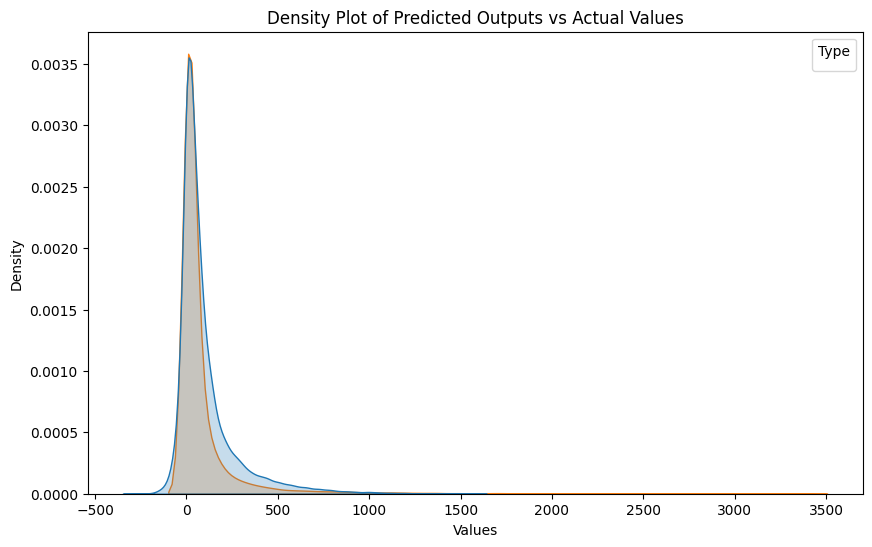

In [28]:
print('Best trial:', study.best_trial)
print('Best value:', study.best_value)
print('Best parameters:', study.best_params)

import lightgbm as lgb

# Assuming study.best_params already includes the best hyperparameters from your Optuna study for a regression problem
model = lgb.LGBMRegressor(**study.best_params)

# Assuming features_no_outliers and target_no_outliers are your feature matrix and target vector, respectively
model.fit(features_no_outliers, target_no_outliers)

# After fitting, you can use the model to predict or evaluate it further
# For example, to predict new values
predictions = model.predict(test_features_no_outliers)

mse = mean_squared_error(test_target_no_outliers, predictions)
mae = mean_absolute_error(test_target_no_outliers, predictions)
r2 = r2_score(test_target_no_outliers, predictions)

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test R^2: {r2}")

df_predictions = pd.DataFrame({
    "Predicted": predictions.flatten(),  # Flatten in case the predictions are in a 2D array
    "Type": "Predicted"
})
df_actual = pd.DataFrame({
    "Predicted": np.tile(Y_test, (len(predictions) // len(Y_test))),
    "Type": "Actual"
})

import matplotlib.pyplot as plt
import seaborn as sns

# Combine and plot
df_combined = pd.concat([df_predictions, df_actual])
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(data=df_combined, x="Predicted", hue="Type", fill=True)
plt.title('Density Plot of Predicted Outputs vs Actual Values')
plt.xlabel('Values')
plt.ylabel('Density')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["Predicted", "Actual"], title="Type")
plt.show()




filename = "lightgbm.pkl"
pickle.dump(model, open(filename, "wb"))

UMAP WITH FEATURES AND MEAN ERROR

UMAP WITH FEATURES AND STD

UMAP WITH TARGET AND MEAN ERROR

UMAP WITH TARGET AND STD